Goal of this notebook is to replicate the NREM theta oscillation pattern that was present in Quinton/Bola's model, where the inhibitory and excitatory neurons synchronized at about 180 degrees out of phase with each other. In order to do this, I will try and change how the backbone is constructed. 

First, I will only focus on a one-backbone model.

Then make inhibiton the same to all excitatory neurons, essentially removing the difference between BB and LE neurons.

In order to regain this distinction, I will first try simply increasing the Idrive to BB neurons.
If that doesn't work, I will try introducing stronger connections between BB cells instead.
If neither work, I will try a combination of the two.

Code taken from "Two Backbones v2".ipynb

In [15]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as RD
from matplotlib import colors
import winsound
import csv
import copy

In [12]:
#It is important to leave numEquations and stepSize here, as they affect the integration.
numEquations = 4
stepSize = 0.1
simLength = 3000
tarray = np.arange(0,simLength,stepSize)
Ntimes = len(tarray)

spikeThreshold = 5 #Sets the voltage(mV) at which a spike is recorded. 

numnrn = 100 #Number of neurons in the model.

numSST = 20 #Number of SST neurons to be forced into the model.
percent_SST = 0 #Percent of neurons to be randomly assigned as SST interneurons.

c_e, c_i = 0.1, 0.5 #Percent connectivity. Excitory, Inhibitory.  
p_e, p_i = 0.8, 0 #Probabilty of an existing connection breaking and forming a new connection. Excitory, Inhibitory. 
local_conn = True #When true, new connections can be formed with local connections. When false, only non-local new
# connections are formed.

gks_E = 0 #ACh level of excitatory neurons. Type I is gks=0, Type II gks=1.5.
gks_SST = 0 # ACh level for SST neurons. 

Idrive_min, Idrive_max = 0.5, 0.5 # Range for possible random Idrives. For excitory neurons.
Idrive_SST = -0.1 #The Idrive for SST neurons. Should be low enough so that they do not fire without synaptic input. 

gsynH,gsynL = 3,3 #High and low gsyn values for recruitee neurons and backbone neurons respectively.

w_max = 2.5 #Maximum positive synaptic plasticity multiplier allowed in network.

makeSound = True
plas_skip = True # When true, a certain amount of time at the beginning of the simulation does not affect plasticity.
RD_seed = True # When true, a seed is used to generate connections
seed = 1 # The seed for generating random numbers/list indices. NOTE: defining a seed before a sequence of random events will
# not only define the outcome of the first random choice/event, but ALSO the following ones. So we only need one seed. 

avg_quad_array = np.empty((1,5)) #Defines array for use in storing connection strength multiplier averages.
avg_quad_array_bbs = np.empty((1,6))

bbs_toplot = [1] #list of backbones to plot by ID.

directory = 'Saved Figures 6-24-21/Different BB/REM/High Idrive to BB/' #The directory for all saved files to be saved to. 


class neuron:
        
    def __init__(self):
        self.ID = 0
        self.position = []
        self.connections = [] #List of (1 or 0) connection strengths to other neurons. Is tuple like [[postsyn,conn],[postsyn,conn]...].
        # DO NOT CHANGE self.connections from values of only 1 and 0 because many apects of the program rely on it.
        self.connectionWeights = [] #Holds changes made from plasticity. For self as presynaptic nrn. Values are strengths of
        # signal to other neurons from this neuron.
        self.Input_syn = 0
        self.Input_noise = 0
        self.Input_external = 0
        self.spikeTimes = [] # Set to record a spike when membrane voltage breaches variable spikeThreshold.
        self.prevActivity = 0
        self.neuronsInRange = [] #Tracks the # of neurons in range so as to minimize looping time during connection growth function
        self.solutions = np.zeros(numEquations) #Why does nrn.solutions still function as a comment?
        
        #Things I have added in myself:
        self.spike = False #Determines whether the neuron has already spiked or not. 
        self.Idrive = 0
        self.color = '' #Color of neuron for graphing.
        self.conn_in = [] #Connections coming in from other neurons. Sum is the in-degree of the neuron. Note, not tuple like self.connections.
        # Format is 1D list of connection strengths, where list index is presynaptic neuron. 
        self.category = 'Excitatory' #Labels the neuron type. Default is excitatory, can be chanegd to inhibitory. 
        self.gsyn = 1 # Connection strength multiplier.
        self.pair_spiketimes = np.zeros(numnrn) #Pair spike times for outgoing connections. Note that this only holds the most recent pair spiketime for each conn.
        self.start_noise = 0 #Starting step time for noise when it occurs (mV/stepSize). 
        self.backbone_ID = 0 # backbone_ID=0 will be used to designate lower E neurons and -1 for inhibitory neurons.
        self.spike_gaussian = [] #List of gaussian curves, each centered at the time a neuron spikes. Each index in list corresponds to a t_ind time.
        self.plas_on = True #Boolean determining whether or not to change plasticity of connections TO and FROM this nrn. 
        self.cw_in_history = [] #Connection weight history. Holds plasticity connection weights coming IN (this nrn as postsyn).
        # Set up as [[[weight from nrn 0, weight from nrn 1, ... ],time(ms)] ,...], one weight list for each time step.
        # List set up to skip first 500 ms because we don't want plasticity due to transient behaviors. Note the default
        # value for connections and non-existent connections is 1. 
        self.scatter_color = 'grey'
        self.scatter_quad_color = 'grey'
        
        
def equations(solns_, eqn, Isyn, Idrive,nrn):
    # These equations are parameters are adjusted to fit fast-spiking interneurons.
    
    tempVal = 0
    
    category = nrn.category
    Inoise = nrn.Input_noise #Noise from neuron. Maybe I should put Idrive, solns, etc here as well?
    
    if category == 'Excitatory':
        gks = gks_E
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn + Inoise)/C
            
    elif category == 'SST':
        gks = gks_SST
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn)/C
            
    elif category == 'PV+':
        C = 1 
        gna = 35
        gkdr = 9
        gl = 0.1
        Vna = 55
        Vk = -90
        Vl = -65    
        if(eqn == 0):
            a_h = 0.07*np.exp(-(solns_[3]+58)/20)
            b_h = 1/(np.exp(-0.1*(solns_[3]+28))+1)
            phi = 5
            tempVal = phi*(a_h*(1-solns_[0]) - b_h*solns_[0])
        elif(eqn == 1):
            a_n = -0.01*(solns_[3]+34)/(np.exp(-0.1*(solns_[3]+34))-1)
            b_n = 0.125*np.exp(-(solns_[3]+44)/80)
            phi = 5
            tempVal = phi*(a_n*(1-solns_[1])-b_n*solns_[1])
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            a_m = -0.1*(solns_[3]+35)/(np.exp(-0.1*(solns_[3]+35))-1)
            b_m = 4*np.exp(-(solns_[3]+60)/18)
            m = a_m/(a_m+b_m)
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn)/C
        
    return tempVal


def RK4(t_ind):
    
    global neuron
    
    for nrn in neurons:
        
        
        solns = nrn.solutions
        Isyn = nrn.Input_syn
        Idrive = nrn.Idrive
        k1 = np.zeros(numEquations)
        k2 = np.zeros(numEquations)
        k3 = np.zeros(numEquations)
        k4 = np.zeros(numEquations)
        
        init_solns = solns
        
        #Calculates the k1 variables
        for ii in range(len(solns)):
            k1[ii] = stepSize*equations(solns, ii,Isyn,Idrive,nrn)

        #Calculates the k2 variables
        for ii in range(len(solns)):
            k2[ii] = stepSize*equations(solns+k1/2, ii,Isyn,Idrive,nrn) #important fix done here. solns must be advanced by k
                                                                    #for calculation of the next k variable.
        #Calculates the k3 variables
        for ii in range(len(solns)):
            k3[ii] = stepSize*equations(solns+k2/2, ii,Isyn,Idrive,nrn) 

        #Calculates the k4 variables
        for ii in range(len(solns)):
            k4[ii] = stepSize*equations(solns+k3, ii,Isyn,Idrive,nrn)
        
        #Updates the general solution
        for ii in range(len(solns)):
            solns[ii] = init_solns[ii] + (k1[ii] + 2*k2[ii] + 2*k3[ii] + k4[ii])/6 
            nrn.solutions[ii] = solns[ii]
            
            
            
def init_nrn(numnrn): #initializes neurons and assigns ID, connections, weights, etc. 
    global neuron
    neurons = [] #List containing neuron objects
    nconn_Mat = [np.empty(3)] # 2D matrix for storing new connections.
    
    if RD_seed: # When true, the simulation will be reproducable entirely (all connections, neuron assignments, initial coniditions).
        RD.seed(seed)
    
    def count_SST(neurons): # A function for counting the number of SST neurons.
        count = 0
        for nrn in neurons:
            if nrn.category == 'SST':
                count += 1
        return count

    
    for i in range(numnrn):  
        neurons = np.append(neurons,neuron()) #Intiallizes numnrn number of neurons
        
        
    #This for loop ensures that exactly numSST number of E neurons are changed to SST.
    for i in range(numSST):
        changed_to_SST = False #Keeps loop running until excitatory neuron is found to change to SST neuron.
        while changed_to_SST == False: #Loop mentioned above.
            nrn = RD.choice(neurons) #grabs one neuron object at random (available for editing)
            if nrn.category == 'Excitatory': #If true, turns excitatory neuron to SST. If neuron is not Excitatory, while loop runs again.
                nrn.category = 'SST'
                nrn.backbone_ID = -1 #Assigns inhibitory neurons to backbone ID = -1.
                changed_to_SST = True
                
    #Create list of only E neurons.
    Eneurons = []
    for nrn in neurons:
        if nrn.category == 'Excitatory':
            Eneurons.append(nrn) #Note that even though this is a different list than neurons, the neuron objects within can be
            # changed all the same like they were in neurons. 
                
                
    #Changes all excitatory neurons to having high inhibition (i.e. like LE neurons):
    for nrn in Eneurons:
        nrn.gsyn = gsynH
    
    
    
    def create_backbones(Eneurons):
        #this function initializes backbones into a network assuming that all E neurons have a high gysn (high inhibition level). 
        # Takes list of excitatory neuron objects as input. WILL NEED TO FIX WITH try->except WHEN num_per_bb > non_bb_size because
        #then LElist will sample too many elements from templist on last run of loop. 
        global neuron 

        num_bb = 1 #number of backbones to create from number of available E neurons
        non_bb_size = 40 #number of non-backbone E neurons to be left in network.
        num_bb_nrns = numnrn - (numSST + non_bb_size) #number of neurons for splitting into backbones.
        num_per_bb = int(num_bb_nrns/num_bb) # number of E neurons per backbone.

        LElist = RD.sample(Eneurons,num_per_bb) #temp list for looping

        for bb in range(1,num_bb+1): #This makes the notation easier by shifitng indicies +1. This is because nrn.backbone_ID=0
        # is reserved for NON-backbone neurons. bb=1 designates backbone_ID=1.
            templist=[]

            for nrn in LElist:
                nrn.backbone_ID = bb # Assigns first randomly chosen group of neurons to the first backbone.
                nrn.gsyn = gsynL #Backbones are created in the "on" state.
                
            for nrn in Eneurons: #Makes a new list with only non-backbone nrns.
                if nrn.backbone_ID == 0:
                    templist.append(nrn)
            LElist = RD.sample(templist,num_per_bb)

        
        
    create_backbones(Eneurons)


    ID = 0
    bb_colors = ['cyan','blue','green','orange','purple'] # Colors for backbones, cyan reserved for non-backbone E neurons.
    for nrn in neurons: #assigns neurons in list their IDs, init voltage, Idrive, etc.
        nrn.ID = ID
        ID += 1 
        nrn.spikeTimes = []
        nrn.solutions = [RD.random(),RD.random(),RD.random(),RD.uniform(-55,-20)] #Initial conditions of each neuron. Initial voltage randomly assigned between -55 and -20 mV.
        #nrn.gsyn = round(RD.uniform(0,3),4) #Chooses a connection multiplier between 0 and x.
        nrn.connectionWeights = [1]*numnrn #Creates a list of all connection weights to other neurons at value 1. 

        if nrn.category == 'Excitatory':
            nrn.Idrive = round(RD.uniform(Idrive_min, Idrive_max),3) #Random value between min and max rounded to 1 decimal places
            nrn.color = bb_colors[nrn.backbone_ID] #Assigns nrn color coded for backbone.
            
        if nrn.category == 'SST':
            nrn.color = 'Red' #Inhibitory given red.
            nrn.Idrive = Idrive_SST #Idrive for inhibitory neurons. 
        if nrn.category == 'PV+':
            nrn.color = 'darkorange'
            nrn.Idrive = round(RD.uniform(Idrive_PVplus_min,Idrive_PVplus_max),3)
    
    conn_Matrix = np.zeros((numnrn,numnrn)) #initializes matrix of zeros with numnrn x numnrn size. Row = nrn #, Column = connected nrn #
    # Fills matrix with connectivity based on proximity. conn_span # of neurons to right and left are given full connection. 
    for row_index, row in enumerate(conn_Matrix):
        for column_index, conn in enumerate(row):
            
            if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
                conn_span = int(c_e*numnrn/2) #number of neurons to be connected on either side of a neuron.

                #sets neurons at +- conn_span from diagonal to full connectivity.
                if column_index >= row_index-conn_span and column_index <= row_index+conn_span:
                    conn = 1 
                #Full connectivity at edge case of first neurons connected to last neurons in ring.
                elif row_index-conn_span < 0 and column_index >= numnrn+row_index-conn_span:
                    conn = 1
                #Full connectivity at edge case of last neurons connected to first neurons in ring.
                elif row_index+conn_span > (numnrn-1) and column_index <= row_index-numnrn+conn_span:
                    conn = 1 
                #All other neurons have zero connectivity.
                else:
                    conn = 0
                # Sets diagonal entries to zero.
                if column_index == row_index:
                    conn = 0
                    
            elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+': # If the presynaptic neuron is inhibitory.
                if RD.random() <= c_i and column_index != row_index: # if a random between 0 and 1 is less than the connectivity percent. 
                    conn = 1
                else:
                    conn = 0
                    
            row[column_index] = conn  #Assigns the local connections.
        conn_Matrix[row_index] = row

    # Changes connections based on proability p. 
    for row_index, row in enumerate(conn_Matrix): 
        row_temp = row.copy() #used to store changes while deleting connections from new_conn_list. VERY IMPORTANT TO USE .copy()
         # otherwise row will change when row_temp is changed. This is how assignment works. 
        if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
            conn_span = int(c_e*numnrn/2) #number of neurons to be connected on either side of a neuron.
            p = p_e
        elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+':
            conn_span = int(c_i*numnrn/2)
            p = p_i 

        for column_index, conn in enumerate(row):
            
            if conn != 0: #only for existing connections.
                if RD.random() <= p: # RD.random() selects random float between 0 and 1.

                    if local_conn == True: # Allows new local connections.
                        new_conn_list = np.append(np.arange(0,row_index,1),np.arange(row_index+1,numnrn,1)) #Creates list of
                        #all nrn IDs besides self.
                    if local_conn == False: #No new local connections.
                        #List of all nrns except local and self. Very gross and uses heaviside functions. May be simplifiable. 
                        new_conn_list = np.append(np.arange(numnrn - numnrn*np.heaviside(row_index-conn_span-1, 1)
                                    +(row_index+conn_span-numnrn+1)*np.heaviside(row_index+conn_span-numnrn,1),row_index-conn_span,1),
                                    np.arange(row_index+conn_span+1,(numnrn+row_index-conn_span)-
                                    (row_index-conn_span)*np.heaviside(row_index-conn_span, 1),1))
                     
                    for index, val in enumerate(row_temp):#Deletes established conns from new_conn_list, preventing double connections.

                        if val != 0: #Sorts out only established conns.
                            delindex = np.where(new_conn_list == index) #Finds where est. conn lies in new_conn_list.
                            if len(delindex[0]) > 0: #Stops error from having nothing to delete when local_conn = False. 
                                delindex = delindex[0][0] #grabs useful integer.
                                new_conn_list = np.delete(new_conn_list, delindex) #deletes from possible conns. 
    
                    nconn = RD.choice(new_conn_list) #Randomly selects one neuron to connect to. 
                    nconn_info = [[row_index, column_index, nconn]] # [neuron #, old connection, new connection]. Must be 2D.
                    nconn_Mat = np.concatenate((nconn_Mat,nconn_info)) #Adds this info to a matrix for later use.
                    
                    #Updates values of the array used in determining new connections. 
                    row_temp[int(column_index)] = 0 
                    row_temp[int(nconn)] = 1


    nconn_Mat = np.delete(nconn_Mat,0,0) #Removes np.empty dummy row from matrix.
    
    #Apply new connection changes.
    for info in nconn_Mat:
        conn_Matrix[int(info[0]),int(info[1])] = 0 #Sets old connection to zero.
        conn_Matrix[int(info[0]),int(info[2])] += 1 #Establishes connection or adds another connection.

    nc_Matrix = np.empty((numnrn,numnrn,2)) #Empty matrix to hold final values. nc means neuron # and connection strength. 
    count = 0
    # Creates 3D array, nc_matrix, storing (nrn #, conn strength to nrn receiving Isyn)
    for row in conn_Matrix:
        conn_tuple = list(enumerate(row)) #list of tuples with info (postsyn nrn #, recieving nrn conn strength)
        nc_Matrix[count] = conn_tuple 
        count += 1

    
    #Assigns neuron objects the list of tuple connections. 
    for nrn in neurons:
        nrn.connections = nc_Matrix[nrn.ID] #Outgoing connections for nrn.
        nrn.conn_in = nc_Matrix[:,nrn.ID][:,1]# Incoming connections for nrn. [0,0,1,1] would mean this neuron recieves no
        # signal from neurons 0 and 1, and full signal from neurons 2 and 3. 
        
        
    def del_crossbb_conns():
        # This function deletes E-E connections between neurons in different backbones. This prevents the activity of one backbone
        # form exciting the other.
        global neuron

        for nrn1 in neurons:
            for nrn2 in neurons:
                #The following checks that nrns are not inhibitory (bb=-1) or lower excitatory (bb=0) and are in different backbones with a connection.
                if nrn1.backbone_ID not in [-1,0] and nrn2.backbone_ID not in [-1,0] and nrn1.backbone_ID != nrn2.backbone_ID and nrn1.connections[int(nrn2.ID)][1] == 1:
                    nrn1.connections[int(nrn2.ID)][1] = 0 #Eliminates connection between neurons.
                
    del_crossbb_conns()
    
    return neurons,nc_Matrix




    
            
def updateSyn(t_ind): #Gives synaptic input to all neurons on connection list
    #Includes changes in synaptic strengths. t_start is the time at which the presynaptic neuron's voltage breaches -20 mV.
    # Has been changed to normalize strength of inputs to a neuron by number of inputs. I.e sum of all inputs comes to w_max. 
    t_temp = 0 
    global neuron

    # AMPA connections
    w_EE = 0.15
    w_EI = 0.08
    # GABA A connections
    w_II = 0.15
    w_IE = 0
    # GABA B connections
    w_II_B = 0
    w_IE_B = 0.05
    
    tau = 0.5 #Time constant for fast-acting receptors.
    tau_B = 50 # Time constant for GABA B receptors, slow-acting.
    
    for nrn in neurons:# presynaptic neurons.         
        if len(nrn.spikeTimes) > 0: # To prevent errors of calling [-1] from an array without any entries. Can change to be l > 2, 3 ...
            t_temp = nrn.spikeTimes[-1] #grabs time this neuron spikes at.

            for conn in nrn.connections: #Gives all postsynaptic neurons Isyn corrspondping to their voltage.
                V = neurons[int(conn[0])].solutions[3] #Voltage of postsynaptic neuron. Note conn[1] is the connection strength and conn[0] is the ID.
                Isyn = 0 
                
                if nrn.category == 'SST' or nrn.category == 'PV+': # Handles GABA A and B receptors in postsyn  neurons.
                    E_syn = -75 #Chloride reversal potential. 
                    if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For I-I connections.
                        for w,t in (w_II,tau),(w_II_B,tau_B): #Sends two signals, one with w_II/tau and one with w_II_B/tau_B. 
                            Isyn += conn[1]*(w)*np.exp(-stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t is tau here. 
                    if neurons[int(conn[0])].category == 'Excitatory': # For I->E connections.
                        gsyn = neurons[int(conn[0])].gsyn #Connection strength multiplier of postsynaptic neuron.
                        for w,t in (w_IE,tau),(w_IE_B,tau_B):
                            Isyn += gsyn*conn[1]*(w)*np.exp(-stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t = tau again. 
                            
                if nrn.category == 'Excitatory':
                    E_syn = 0 # Sodium reversal potential. E_syn = 0 for excitory synapse and E_syn = -75 mV for inhibitory synapse
                    if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For E->I connections.
                        Isyn = conn[1]*(w_EI)*np.exp(-stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                    if neurons[int(conn[0])].category == 'Excitatory': # For E-E connections.
                        Isyn = nrn.connectionWeights[int(conn[0])]*conn[1]*(w_EE)*np.exp(-stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                    
                neurons[int(conn[0])].Input_syn += Isyn #Isyn going to Postsynaptic neuron.
      
        #Additional portion of updateSyn() for calculating noise probabilities. INDENTATION IS IMPORTANT! MUST BE IN nrn LOOP.
        noise_mag = 40 #Magnitude of noise input in mV. 
        probability = 2*10**(-4) #Probability in every integration step that a noise spike will occur for each neuron.
        t_noise = nrn.start_noise 
        global neuron

        if RD.random() <= probability: #Handles the start of a noise spike.
            #print('Noise Spike at Time ',t_ind*stepSize)
            Inoise = noise_mag
            nrn.start_noise = t_ind #Time at which noise begins 
        elif nrn.Input_noise != 0 and (t_ind - t_noise)*stepSize <= 1: #extends noise input for 1 ms.
            Inoise = noise_mag
        else:
            Inoise = 0 #When there is no noise. 

        nrn.Input_noise = Inoise # Applies noise to neuron. 

    
    
    
            
def updateSpikeTime(t_ind):
    global neuron
    # Variables for synaptic plasticity:
    A = 0.6/10 # The maximum amount a synapse can change in strength per spike.
    tau = 10 # Time constant for exponential function in ms.
    
    skip_time = 20 #Time before spikes start being recorded (in ms).
    if plas_skip:
        skip_time = 500 #skips first 500 ms to avoid making plasticity changes based on transient behaviors. Most useful for 
        # networks with high gks_Inhibitory levels. 
    
    dep_thr = 1 #Depotentiation-only rule threshold frequency(Hz). Firing of neuron pairs below this frequency will only depotentiate.
    pot_thr = 10 #Bi-directional rule upper threshold and potentiation-only lower theshold frequency(Hz). Firing between
    # dep_thr and pot_thr will be subject to bi-rule, while firing above pot_thr subject to potentiation only. 
    
    w_dep = 5 #The multiplier for plasticity caused by depotentiation-only rule.
    
    for nrn in neurons:
        
        # Recording the incoming connection plasticity weights for each neuron:
        if t_ind % (1/stepSize) == 0 and t_ind*stepSize > skip_time: #Only runs code every ms (t_ind with only zero in decimal place). Also skips first 500 ms of no plasticity.
            presyn_weight_list = np.ones(numnrn) #List for storing weight connections from each presyn neuron.
            for presyn_ID in range(numnrn): #Loops through presynaptic connections to nrn.
                presyn_weight_list[int(presyn_ID)] = neurons[int(presyn_ID)].connectionWeights[int(nrn.ID)] #Records value 
                # of connection weight from presynaptic neuron.
            nrn.cw_in_history.append([presyn_weight_list,t_ind*stepSize]) #Appends conn weight values to history. 

        # Recording spike times:
        if nrn.solutions[3] >= spikeThreshold and nrn.spike == False and (t_ind*stepSize) > skip_time: #Selects spikes, skips anything before the first "skip_time" ms. 
            nrn.spikeTimes = np.append(nrn.spikeTimes, t_ind) #Records (time/stepSize) of a spike.
            nrn.spike = True
                        
            if nrn.plas_on == True: #If nrn's plas_on is True, plasticity(to and from) nrn is allowed to change. If False, it is frozen.

                #Changes synaptic weights. Note, nrn.connections is a tuple [postsyn, conn] while nrn.conn_in is simply a list of conns where the index is the presyn.
                # This works using only spikes that have already occured, so in-conns will always be strengthened and out-conns always weakened.
                for postsyn,conn in nrn.connections: # The outgoing connections. This weakens synapses. 

                    if conn == 1 and nrn.category == 'Excitatory' and neurons[int(postsyn)].category == 'Excitatory' \
                    and len(neurons[int(postsyn)].spikeTimes) > 0 and neurons[int(postsyn)].spikeTimes[-1] >= (nrn.spikeTimes[-1] - 30/stepSize)\
                    and neurons[int(postsyn)].plas_on == True: #Excludes all neurons that haven't spiked in the last 30 ms.
                            pair_spiketime = stepSize*(nrn.spikeTimes[-1] - (nrn.spikeTimes[-1]-neurons[int(postsyn)].spikeTimes[-1])/2) #Spike time of neuron pair in ms.

                            # If pair firing frequency is below dep_thr Hz. Also prevents initial pair_spiketimes value of zero from causing unwanted initial depotentiation.
                            if (pair_spiketime - nrn.pair_spiketimes[int(postsyn)]) >= 1000/dep_thr and nrn.pair_spiketimes[int(postsyn)] != 0:
                                nrn.connectionWeights[int(postsyn)] += -w_dep*A*np.exp((-stepSize*abs(neurons[int(postsyn)].spikeTimes[-1] 
                                                                                           - nrn.spikeTimes[-1]))/tau)# Weaken synapse.
                                if nrn.connectionWeights[int(postsyn)] < 0:
                                    nrn.connectionWeights[int(postsyn)] = 0 #This prevents synaptic weakening below zero, which would simulate inhibition.

                            if 1000/dep_thr > (pair_spiketime - nrn.pair_spiketimes[int(postsyn)]) >= 1000/pot_thr: #Determines pair firing frequency bsed off last fire. Selects firing between dep_thr and pot_thr frequencies (Hz).
                                nrn.connectionWeights[int(postsyn)] += -A*np.exp((-stepSize*abs(neurons[int(postsyn)].spikeTimes[-1]
                                                                                                - nrn.spikeTimes[-1]))/tau)# Weaken synapse.
                                if nrn.connectionWeights[int(postsyn)] < 0:
                                    nrn.connectionWeights[int(postsyn)] = 0 #This prevents synaptic weakening below zero, which would simulate inhibition.
                                #print('Synapse from ',nrn.ID,' to ',postsyn,' weakened to ',nrn.connectionWeights[int(postsyn)])
                            if pair_spiketime - nrn.pair_spiketimes[int(postsyn)] < 1000/pot_thr: #If frequency is greater than pot_thr Hz. 
                                nrn.connectionWeights[int(postsyn)] += A*np.exp((-stepSize*abs(neurons[int(postsyn)].spikeTimes[-1] - nrn.spikeTimes[-1]))/tau)# Strengthen synapse.
                                if nrn.connectionWeights[int(postsyn)] > w_max:
                                    nrn.connectionWeights[int(postsyn)] = w_max #Caps strength at w_max.

                            nrn.pair_spiketimes[int(postsyn)] = pair_spiketime #Updates pair spiketime.

                for presyn,conn in enumerate(nrn.conn_in): # Incoming connections.

                    if conn == 1 and nrn.category == 'Excitatory' and neurons[int(presyn)].category == 'Excitatory' \
                    and len(neurons[int(presyn)].spikeTimes) > 0 and neurons[int(presyn)].spikeTimes[-1] >= (nrn.spikeTimes[-1] - 30/stepSize)\
                    and neurons[int(presyn)].plas_on == True:
                        pair_spiketime = stepSize*(nrn.spikeTimes[-1] - (nrn.spikeTimes[-1]-neurons[int(presyn)].spikeTimes[-1])/2) #Spike time of neuron pair in ms.

                        # If pair firing frequency is below dep_thr Hz. Also prevents initial pair_spiketimes value of zero from causing unwanted initial depotentiation.
                        if (pair_spiketime - neurons[int(presyn)].pair_spiketimes[int(nrn.ID)]) >= 1000/dep_thr and neurons[int(presyn)].pair_spiketimes[int(nrn.ID)] != 0:  
                            neurons[int(presyn)].connectionWeights[int(nrn.ID)] += -w_dep*A*np.exp((-stepSize*abs(neurons[int(presyn)].spikeTimes[-1] 
                                                                                            - nrn.spikeTimes[-1]))/tau)# Weaken synapse.
                            if neurons[int(presyn)].connectionWeights[int(nrn.ID)] < 0:
                                neurons[int(presyn)].connectionWeights[int(nrn.ID)] = 0 #This prevents synaptic weakening below zero, which would simulate inhibition.

                        if 1000/dep_thr > (pair_spiketime - neurons[int(presyn)].pair_spiketimes[int(nrn.ID)]) >= 1000/pot_thr: 
                            neurons[int(presyn)].connectionWeights[int(nrn.ID)] += A*np.exp((-stepSize*abs(neurons[int(presyn)].spikeTimes[-1] 
                                                                                            - nrn.spikeTimes[-1]))/tau) #Strengthens synapse.
                            if neurons[int(presyn)].connectionWeights[int(nrn.ID)] > w_max:
                                neurons[int(presyn)].connectionWeights[int(nrn.ID)] = w_max # Caps strength at w_max.
                            #print('Synapse from ',presyn,' to ',nrn.ID,' strengthened to ',neurons[int(presyn)].connectionWeights[int(nrn.ID)])
                        if pair_spiketime - neurons[int(presyn)].pair_spiketimes[int(nrn.ID)] < 1000/pot_thr: #For frequencies greater than pot_thr Hz.
                            neurons[int(presyn)].connectionWeights[int(nrn.ID)] += A*np.exp((-stepSize*abs(neurons[int(presyn)].spikeTimes[-1] 
                                                                                            - nrn.spikeTimes[-1]))/tau) #Strengthens synapse.
                            if neurons[int(presyn)].connectionWeights[int(nrn.ID)] > w_max:
                                neurons[int(presyn)].connectionWeights[int(nrn.ID)] = w_max # Caps strength at w_max.

                        neurons[int(presyn)].pair_spiketimes[int(nrn.ID)] = pair_spiketime #Updates pair spiketime.   
                    
        if nrn.solutions[3] <= -30 and nrn.spike == True: #Resets the spiking status, allows for next spike to be recorded. 
            nrn.spike = False
            
            
'---------------------------------------------------------------------------'      

            
def vary_param(t_ind): #Changes gks of network. I am also added in a component to weaken all synapses after NREM.
    global gks_E, gks_SST #Allows changes to these global variables to be made inside function.
    global neuron
    
    #Vary gks:
    t = t_ind*stepSize #changes t_ind to ms.
    gt_list = [] #List containing gks values and the time to impliment them. [[gks val,time(ms)],[...]].
    
    times = [i[1] for i in gt_list] # creates list of times from the gt_list.
    if t in times:
        gks_val = gt_list[times.index(t)][0] # assigns gks_val the corresponding gks value.
        gks_E,gks_SST = gks_val,gks_val #Changes the global variable(s) for gks in the network.
        
    #Vary backbone activity:
    # List indicating times and implimentations. [ [ ['on',[bbs to turn on],'off',[bbs to turn off] ], time(ms)] , [...] ]
    bbt_list = []

    times_bb = [i[1] for i in bbt_list]
    if t in times_bb:
        print('onoff triggered at',t)
        #'On' Operations:
        on_off = bbt_list[times_bb.index(t)][0][0] #This grabs the 'on' string
        bb_toswitch = bbt_list[times_bb.index(t)][0][1] #Grabs bb IDs to be turned on.
        bb_onoff(on_off,bb_toswitch)
        #'Off' Operations:
        on_off = bbt_list[times_bb.index(t)][0][2] #This grabs the 'off' string
        bb_toswitch = bbt_list[times_bb.index(t)][0][3] #Grabs bb IDs to be turned off.
        bb_onoff(on_off,bb_toswitch)
        
    #Vary plasticity activity:
    #List for turning off plasticity to and from specific bbs or LE neurons. [[LE,bb1,bb2],time] , ...
    plas_onoff_list = [[[True,True,False],0]]
    
    times_plas = [i[1] for i in plas_onoff_list]
    if t in times_plas: #If the simulation reaches one of desired times:
        plas_boo_list = plas_onoff_list[times_plas.index(t)][0] #Assigns plas_on the boolean associated with time t. 
        
        for nrn in neurons: #Changes plas_on attribute for all neurons to match plas_boo_list vals. Uses index. 
            nrn.plas_on = plas_boo_list[int(nrn.backbone_ID)]
        
        
'-------------------------------------------------------------------------'   
        
            
def zeroTempVars(): #Zeros all variables to prevent accidental accumulation of unwanted terms. Just a safety measure, good habit.
        #Note: Do not zero solutions, because they are used in calculating next solutions. 
        global neuron
        for nrn in neurons:
            nrn.Input_syn = 0 #Zeroed because ISyn must be added to account for input from multiple neurons. If Isyn was
            # simply assigned, the Isyn would not accumulate. But now it must be zeroed. 
            
            
def plot(tarray,nc_matrix): #Plots neuron spikes
    
    #Plots pixel-plot of neuron connectivities.
    fig, ax = plt.subplots(1,figsize=(12,12))
    connplot = ax.imshow(nc_Matrix[:,:,1], extent=(0,numnrn,0,numnrn), cmap='cividis') #Generates pixel-like plot of connection strengths.
    ax.grid(which='both', axis='both', color='black', linewidth=1)
    ax.set_xticks(np.arange(0,numnrn,1)) #Sets lines for axes, off of which the grid is based.
    ax.set_yticks(np.arange(0,numnrn,1))
    ax.set_title('Neuron Connectivity Graphic', size=20)
    ax.set_xlabel('Postsynaptic Neuron ID',size=12)
    ax.set_ylabel('(numnrn - Presynaptic Neuron ID)',size=12);
    
    
    
    #Plots Raster plot of neuron spikes.
    fig, ax1 = plt.subplots(1,figsize=(20,5))
    start = 0/stepSize #time to start plotting from.
    
    list1,list2 = [],[]
    for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
        if nrn.category == 'SST' or nrn.category == 'PV+':
            list1.append(nrn.ID)
        if nrn.category == 'Excitatory':
            list2.append(nrn.ID)
    neuron_list = list1 + list2 #Adds the two lists such that inhibitory neurons come first and excitory second.
    
    for index, ID in enumerate(neuron_list):
        spikeTimes_toplot = []
        
        for t in neurons[ID].spikeTimes: # Runs through spike times of every neuron in 'neuron_list', starting with inhibitory.3
            if t >= start: #only selects times greater than 'start' for plotting.
                spikeTimes_toplot = np.append(spikeTimes_toplot,t*stepSize)
        index_plot_list = [index]*len(spikeTimes_toplot)
        ax1.scatter((spikeTimes_toplot),index_plot_list,c=neurons[ID].color,s=2) # c controls nrn dot color, s controls dot size.
        
    ax1.set_title('Raster Plot | ACh Levels: gks_E={0}, gks_SST={1} | Idrive_E={2}, Idrive_SST={3}'
                  .format(gks_E,gks_SST,Idrive_min,Idrive_SST))
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Red - SST, Blue - Excitatory')

    
    
def sort_gsyn(item): #Function for returning the gsyn of a neuron
    # Built to handle nrn simply as an object, and also as a list [nrn_object,index_val].
    if isinstance(item,tuple): #if item is a tuple.
        val = item[0].gsyn    
    elif isinstance(item,neurons[0].__class__): #If this item is object type of a neuron.
        val = item.gsyn
    elif isinstance(item, list): #If item is a list.
        val = item[0].gsyn
    else:
        print("Exception: val=0 in sort_gsyn.")
        val=0
    return val


def sort_Idrive(nrn):
    return nrn.Idrive


def sort_bb(nrn):
    val = nrn.backbone_ID
    return val

def sort_bb_tuple(list1):
    val = list1[0].backbone_ID
    return val
                    
def sort_tuple(tup): #Sorts tuple by first element.
    val = tup[0]
    return val
    
    
def plot_sorted_bb(start_time, nc_Matrix):
    plot_raster = True
    plot_connection_mat = False
    plot_weight_mat = False
    
    list_i,list_e = [],[]
    for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
        if nrn.category == 'SST' or nrn.category == 'PV+':
            list_i.append(nrn) #Appends full nrn object (not just the ID) to make sorting by gsyn easier.
        if nrn.category == 'Excitatory':
            list_e.append(nrn)
    list_e.sort(key=sort_bb) # Sorts list by key function. Can reverse order of sort with reverse=True. 
    list_i.sort(key=sort_bb)
    neuron_list = list_i + list_e #Adds the two lists such that inhibitory neurons come first and excitory second.
    
    
    if plot_raster: #Plots raster plot of neuron spikes. Ordered with inhibitory on the bottom, followed by sorted E neurons.
        fig, ax1 = plt.subplots(1,figsize=(20,5))
        start = start_time/stepSize #time to start plotting from.

        for index, nrn in enumerate(neuron_list):
            spikeTimes_toplot = []

            for t in nrn.spikeTimes: # Runs through spike times of every neuron in 'neuron_list', starting with inhibitory.3
                if t >= start: #only selects times greater than 'start' for plotting.
                    spikeTimes_toplot = np.append(spikeTimes_toplot,t*stepSize)

            index_plot_list = [index]*len(spikeTimes_toplot)
            ax1.scatter((spikeTimes_toplot),index_plot_list,c=nrn.color,s=2) # c controls nrn dot color, s controls dot size.

        ax1.set_title('BB Raster Plot | ACh Levels: gks_E={0}, gks_SST={1} | Idrive_E={2}, Idrive_SST={3} | gsynH={4}, gsynL={5}'
                      .format(gks_E,gks_SST,Idrive_min,Idrive_SST,gsynH,gsynL))
        ax1.set_xlabel('Time (ms)')
        ax1.set_ylabel('Plots sorted from key low to high');
        fig.savefig(directory+'Raster.pdf',format='pdf') #Saves figure as a pdf file to Zochowski Lab under directory. 
    
    
    # Reorders the rows of the connection matrix so as to match the sorted raster plot. 
    # Then plots the new matrix.
    if plot_connection_mat:
        reorder_list = []

        for nrn in neuron_list:
            reorder_list.append(nrn.ID)

        reorder_list.reverse() #Reverses order to match the setup of raster plot.
        reor_mat = nc_Matrix[reorder_list] # Creates new matrix reor_mat that is the reordered version of nc_Matrix.

        #Plots pixel-plot of neuron connectivities.
        fig, (ax_conn, ax_w) = plt.subplots(2,figsize=(12,24))
        connplot = ax_conn.imshow(reor_mat[:,:,1], extent=(0,numnrn,0,numnrn), cmap='cividis') #Generates pixel-like plot of connection strengths.
        ax_conn.grid(which='both', axis='both', color='black', linewidth=1)
        ax_conn.set_xticks(np.arange(0,numnrn,1)) #Sets lines for axes, off of which the grid is based.
        ax_conn.set_yticks(np.arange(0,numnrn,1))
        ax_conn.set_title('Reordered Neuron Connectivity Graphic', size=20)
        ax_conn.set_xlabel('Postsynaptic Neuron ID',size=12)
        ax_conn.set_ylabel('(numnrn - Presynaptic Neuron ID)',size=12);
        
        # Plots matrix ordered like raster plot of connection weights due to plasticity. 
    if plot_weight_mat:
        # Creates matrix of connection weights.
        weight_mat = np.empty((numnrn,numnrn))
        for nrn in neurons:
            weight_mat[int(nrn.ID)] = nrn.connectionWeights
        reor_w_mat = weight_mat[reorder_list]

        # Plots the matrix and colorbar
        weightplot = ax_w.imshow(reor_w_mat,extent=(0,numnrn,0,numnrn),cmap='BuPu')
        ax_w.grid(which='both', axis='both', color='black', linewidth=1)
        ax_w.set_xticks(np.arange(0,numnrn,1)) #Sets lines for axes, off of which the grid is based.
        ax_w.set_yticks(np.arange(0,numnrn,1))
        cbar = fig.colorbar(weightplot,shrink=0.8)
        cbar.set_label('Synaptic Weight Multiplier')
        ax_w.set_title('Network Synaptic Weights', size=20)
        ax_w.set_xlabel('Postsynaptic Neuron ID',size=12)
        ax_w.set_ylabel('(numnrn - Presynaptic Neuron ID)',size=12);


        
def plot_mat_onlyE_b(t_ind): # Function that creates new connection and weight matrices from scratch and includes only excitatory neurons.
    # NOTE: the axis labelling does not match nrn.ID and is only for use with the matrix.
    plot_conn_sorted = False
    plot_plas_sorted = True
    
    #Create list of only E neurons.
    neurons_E = []
    for nrn in neurons:
        if nrn.category == 'Excitatory':
            neurons_E.append(nrn)
    neurons_E.sort(key=sort_bb,reverse=True) # Sorts list by key function. Can reverse order of sort with reverse=True. 

    conn_mat_E = np.empty((len(neurons_E),len(neurons_E)))  # Initialize connection matrix.
    w_mat_E = np.empty((len(neurons_E),len(neurons_E))) # Initialize weight matrix.
    
    for index,nrn in enumerate(neurons_E): #runs through sorted list of E neurons.
        connections_out = nrn.connections # Creates 2D lists of connections and connection IDs.
        conn_weights = nrn.connectionWeights #1D list of connection weights for outgoing connections
        zip_list = list(zip(neurons,connections_out,conn_weights)) #puts nrn connection val, and weight in tuples.
        zip_list.sort(key=sort_bb_tuple,reverse=True) #Sorts tuples based on gsyn of nrns. 
        sorted_conn_out = np.array([conn for nrn,conn,weight in zip_list]) #extracts connections sorted by gsyn. This sorts of the columns in the conn matrix.d
        sorted_weight = np.array([weight for nrn,conn,weight in zip_list]) #extracts weight sorted by gsyn. 

        for postsyn_ID,conn in sorted_conn_out:
            if neurons[int(postsyn_ID)].category != 'Excitatory': #Eliminates connections to I neurons from list.
                sorted_weight = np.delete(sorted_weight,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) # Deletes element from connection weights list. THIS MUST COME BEFORE deleting connections out element.
                sorted_conn_out = np.delete(sorted_conn_out,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) #Deletes terms that are not going to excitatory neurons.
        
        conn_mat_E[index] = sorted_conn_out[:,1] #assigns rows in matrix as modified connection list.
        w_mat_E[index] = sorted_weight #These two matrices are already sorted once all rows are put in!

    
    if plot_conn_sorted:
        #Plots sorted pixel-plot of neuron connectivities.
        fig, ax = plt.subplots(1,figsize=(10,10))
        connplot = ax.imshow(conn_mat_E, extent=(0,len(neurons_E),0,len(neurons_E)), cmap='cividis') #Generates pixel-like plot of connection strengths.
        ax.grid(which='both', axis='both', color='black', linewidth=1)
        ax.set_xticks(np.arange(0,len(neurons_E),1)) #Sets lines for axes, off of which the grid is based.
        ax.set_yticks(np.arange(0,len(neurons_E),1))
        ax.tick_params(labelbottom=False,labelleft=False)#Turns off number labels
        ax.set_title('Excitatory Only Neuron Connectivity Graphic - Sorted', size=20)
        ax.set_xlabel('Postsynaptic E Neuron',size=12)
        ax.set_ylabel('Presynaptic E Neuron (Raster Plot Order)',size=12);

    #Creates custom cmap:
    colors_array = np.array(['purple','white','darkgreen'])
    bounds_array = np.array([0,1,w_max])
    norm = plt.Normalize(min(bounds_array),max(bounds_array))
    tuples = list(zip(map(norm,bounds_array),colors_array))
    cmap = colors.LinearSegmentedColormap.from_list("my cmap",tuples)

    if plot_plas_sorted:
        # Plots synaptic weight matrix and colorbar
        fig, ax_w = plt.subplots(1,figsize=(12,12))
        weightplot = ax_w.imshow(w_mat_E,extent=(0,len(neurons_E),0,len(neurons_E)), norm=norm, cmap=cmap)
        ax_w.grid(which='both', axis='both', color='black', linewidth=1)
        ax_w.set_xticks(np.arange(0,len(neurons_E),1)) #Sets lines for axes, off of which the grid is based.
        ax_w.set_yticks(np.arange(0,len(neurons_E),1))
        ax_w.tick_params(labelbottom=False,labelleft=False)#Turns off number labels
        cbar = fig.colorbar(weightplot,shrink=0.8)
        cbar.set_label('Synaptic Weight Multiplier')
        ax_w.set_title('Excitatory Synaptic Weights - Sorted | t={0}'.format(int(t_ind*stepSize)), size=20)
        ax_w.set_xlabel('Postsynaptic E Neuron',size=12)
        ax_w.set_ylabel('Presynaptic E Neuron (Raster Plot Order)',size=12);
    
    # This function also averages synaptic weights from different portions of the weight matrix.
    top_left,top_right,bottom_left,bottom_right = 0,0,0,0
    # For separating above and below matrix diagonal.
    top_left_above, top_left_below, bottom_right_above, bottom_right_below = 0,0,0,0
    # Averages different synaptic weights
    for row_index, row in enumerate(w_mat_E): #Loops over rows.
        for column_index, conn in enumerate(row): #Loops over each value in given row.
            
            if row_index < np.shape(w_mat_E)[0]/2: #top half of rows
                if column_index < np.shape(w_mat_E)[1]/2: #left half of columns
                    top_left += conn - 1 #Adds to total of change in synaptic weight
                    if column_index > row_index: #This portion sums above and below matrix diagonal.
                        top_left_above += conn - 1
                    elif column_index < row_index:
                        top_left_below += conn - 1
                    
                elif column_index >= np.shape(w_mat_E)[1]/2: # Right half of columns
                    top_right += conn - 1
            
            if row_index >= np.shape(w_mat_E)[0]/2: #bottom half of rows:
                if column_index < np.shape(w_mat_E)[1]/2: #left half of columns
                    bottom_left += conn - 1 #Adds to total of change in synaptic weight
                    
                elif column_index >= np.shape(w_mat_E)[1]/2: # Right half of columns
                    bottom_right += conn - 1
                    if column_index > row_index: #This portion sums above and below matrix diagonal.
                        bottom_right_above += conn - 1
                    elif column_index < row_index:
                        bottom_right_below += conn - 1
                    
    # Divides the sums by a quarter of the number of possible connections (subtracting the diagonal of self connections)                
    top_left,top_right,bottom_left,bottom_right = np.array([top_left,top_right,bottom_left,bottom_right])/((np.shape(w_mat_E)[0]**2 - np.sqrt(2*np.shape(w_mat_E)[0]**2))/4)
    #print('Average change in synaptic weight, t=',int(t_ind*stepSize),'ms. Top Left: ',round(top_left,4),' Top Right: ',round(top_right,4),' Bottom Left: ',round(bottom_left,4),' Bottom Right: ',round(bottom_right,4))

    # Does the same for above and below diagonals
    #top_left_above, top_left_below, bottom_right_above, bottom_right_below = np.array([top_left_above, top_left_below, bottom_right_above, bottom_right_below])/((((np.shape(sorted_w_mat_E)[0]**2 - np.sqrt(2*np.shape(sorted_w_mat_E)[0]**2))/4) - np.sqrt(np.shape(sorted_w_mat_E)[0]**2))/2)
    #print('Diagonals: Top Left Above: ',round(top_left_above,4),' Top Left Below: ',round(top_left_below,4),' Bottom Right Above: ',round(bottom_right_above,4),' Bottom Right Below: ',round(bottom_right_below,4))
    
    return w_mat_E,conn_mat_E
    
    
def plot_bb_mat(t_ind, bbs_toplot,show_mats): #PLots seperate E conn and plas matrices for each bb. bb_toplot is list of bb IDs to be plotted.
    # Note bbs must be in order: [1,2,3,...] or else will get labeled incorrectly on matrices. Show_mats is boolean, True to
    # plot any matrices, False not to. 
    plot_conn = False
    plot_plas = True
    
    #Create list of only E neurons.
    neurons_E = []
    for nrn in neurons:
        if nrn.category == 'Excitatory':
            neurons_E.append(nrn)
    neurons_E.sort(key=sort_bb,reverse=True)
    neurons_E = np.array(neurons_E) #Changing to an array.
    
    conn_mat_list = [] #list to store conn matrices 
    w_mat_list = []
    
    
    for bb in bbs_toplot:
        #Selecting only bb and lower E neurons.
        bb_nrns = []
        for nrn in neurons_E:
            if nrn.backbone_ID == 0 or nrn.backbone_ID == bb:
                bb_nrns.append(nrn)
  
        conn_mat = np.empty((len(bb_nrns),len(bb_nrns)))
        w_mat = np.empty((len(bb_nrns),len(bb_nrns)))
        
        for index,nrn in enumerate(bb_nrns): #runs through sorted list of bb nrns
            connections_out = nrn.connections # Creates 2D lists of connections and connection IDs.
            conn_weights = nrn.connectionWeights #1D list of connection weights for outgoing connections
            zip_list = list(zip(neurons,connections_out,conn_weights)) #puts nrn connection val, and weight in tuples.
            zip_list.sort(key=sort_bb_tuple, reverse=True) #Sorts tuples based on gsyn of nrns. 
            sorted_conn_out = np.array([conn for nrn,conn,weight in zip_list]) #extracts connections sorted by gsyn. This sorts of the columns in the conn matrix.d
            sorted_weight = np.array([weight for nrn,conn,weight in zip_list]) #extracts weight sorted by gsyn. 

            for postsyn_ID,conn in sorted_conn_out:
                if neurons[int(postsyn_ID)].category != 'Excitatory' or (neurons[int(postsyn_ID)].backbone_ID != 0 and neurons[int(postsyn_ID)].backbone_ID != bb): #Eliminates connections to I neurons and other bb
                    sorted_weight = np.delete(sorted_weight,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) # Deletes element from connection weights list. THIS MUST COME BEFORE deleting connections out element.
                    sorted_conn_out = np.delete(sorted_conn_out,np.where(sorted_conn_out[:,0]==postsyn_ID),axis=0) #Deletes terms that are not going to excitatory neurons.

            conn_mat[index] = sorted_conn_out[:,1] #assigns rows in matrix as modified connection list.
            w_mat[index] = sorted_weight #These two matrices are already sorted once all rows are put in!
        
        if plot_conn and show_mats:
            #Plots sorted pixel-plot of neuron connectivities.
            fig, ax = plt.subplots(1,figsize=(8,8))
            connplot = ax.imshow(conn_mat, extent=(0,len(bb_nrns),0,len(bb_nrns)), cmap='cividis') #Generates pixel-like plot of connection strengths.
            ax.grid(which='both', axis='both', color='black', linewidth=1)
            ax.set_xticks(np.arange(0,len(bb_nrns),1)) #Sets lines for axes, off of which the grid is based.
            ax.set_yticks(np.arange(0,len(bb_nrns),1))
            ax.tick_params(labelbottom=False,labelleft=False)#Turns off number labels
            ax.set_title('E Only Connectivity Matrix, bb#{0}'.format(bb), size=20)
            ax.set_xlabel('Postsynaptic E Neuron',size=12)
            ax.set_ylabel('Presynaptic E Neuron (Raster Plot Order)',size=12);

        #Creates custom cmap:
        colors_array = np.array(['purple','white','darkgreen'])
        bounds_array = np.array([0,1,w_max])
        norm = plt.Normalize(min(bounds_array),max(bounds_array))
        tuples = list(zip(map(norm,bounds_array),colors_array))
        cmap = colors.LinearSegmentedColormap.from_list("my cmap",tuples)

        if plot_plas and show_mats:
            # Plots synaptic weight matrix and colorbar
            fig, ax_w = plt.subplots(1,figsize=(10,10))
            weightplot = ax_w.imshow(w_mat,extent=(0,len(bb_nrns),0,len(bb_nrns)), norm=norm, cmap=cmap)
            ax_w.grid(which='both', axis='both', color='black', linewidth=1)
            ax_w.set_xticks(np.arange(0,len(bb_nrns),1)) #Sets lines for axes, off of which the grid is based.
            ax_w.set_yticks(np.arange(0,len(bb_nrns),1))
            ax_w.tick_params(labelbottom=False,labelleft=False)#Turns off number labels
            cbar = fig.colorbar(weightplot,shrink=0.8)
            cbar.set_label('Synaptic Weight Multiplier')
            ax_w.set_title('E Synaptic Weights, bb#{0} | t={1}'.format(bb,int(t_ind*stepSize)), size=20)
            ax_w.set_xlabel('Postsynaptic E Neuron',size=12)
            ax_w.set_ylabel('Presynaptic E Neuron (Raster Plot Order)',size=12);
            fig.savefig(directory+'Plasticity Matrix bb#{0}.pdf'.format(bb),format='pdf')
            
        conn_mat_list.append(conn_mat) #stores matrix in list. Stored in same order as bb_toplot.
        w_mat_list.append(w_mat)
        
    return w_mat_list, conn_mat_list
    
    
def plot_voltage(V_data): #Plots the voltages of all neurons.
    fig, stimplot = plt.subplots(1,figsize=(15,5))
    stimplot.set_xlabel('time (ms)')
    stimplot.set_ylabel('Voltage (mV)')
    stimplot.set_title('Neuron Voltages')

    start = int(0*Ntimes) #index for viewing only portions of graph. Set to 0*Ntimes for normal graph.
    end = int(simLength*Ntimes)
    for index,V_list in enumerate(V_data):
        stimplot.plot(tarray[start:end],V_list[start:end],color=neurons[index].color,label='Idrive {0}'.format(neurons[index].Idrive))
        
    stimplot.legend()
    tens = np.zeros(len(tarray))
    tens += spikeThreshold
    stimplot.plot(tarray[start:end],tens[start:end],'--r')
    
    
def plot_weight(w_data): #Plots the synaptic weights of all connections of all neurons over time.
    fig, stimplot = plt.subplots(1,figsize=(15,5))
    stimplot.set_xlabel('time (ms)')
    stimplot.set_ylabel('Synaptic Weight')
    stimplot.set_title('Change of synaptic weights over time')

    start = int(0*Ntimes) #index for viewing only portions of graph. Set to 0*Ntimes for normal graph.
    end = int(simLength*Ntimes)
    for index,w_list in enumerate(w_data):
        w_list = np.delete(w_list,index,axis=1) #This removes the nonexistant "connection to self" weight variable.
        stimplot.plot(tarray[start:end],w_list[start:end],color=neurons[index].color,label='Presyn nrn {0}'.format(neurons[index].ID))
        
    stimplot.legend()
    

    
    
def beep(makeSound): #Makes a series of beeps. Meant to signal end of code-running. 
    if makeSound: #When True, plays beeps.
        winsound.Beep(349,500)
        winsound.Beep(440,500)
        winsound.Beep(523,500)
        
        
def Avg_MPC(t_start): #Prints the average mean phase coherence over the entire network. 1 means perfect coherence, i.e. all neurons are locked in phase. 
    #Be CAREFUL to check that the stepSize referenced in this function matches that used in the simulation!!
    # t_start gives a time at which after to calculate, allowing for skipping of transients. t_start is in ms. 
    MPC_list = []
    for nrnb in neurons:
        for nrna in neurons:
            if nrnb.ID != nrna.ID and len(nrna.spikeTimes) > 0:
                phi_list = [] 
                MPC_ab_complex = 0 #initiate variables.
                for t_bk in nrnb.spikeTimes: 
                    if t_bk*stepSize >= t_start:
                        t_ak = max(np.where(nrna.spikeTimes < t_bk, nrna.spikeTimes, 0)) #Finds the latest spiketime from nrna that is
                        # smaller than nrnb.
                        t_ak1 = min(np.where(nrna.spikeTimes >= t_bk, nrna.spikeTimes, nrna.spikeTimes[-1]+1))# Finds earliest spiketime
                        # after or equal to spike from nrnb. When one of the neurons is not spiking, edge case assigned. 
                        if t_ak != 0 and t_ak1 <= nrna.spikeTimes[-1]: #Eliminating edge cases.
                            phi_k = 2*round(np.pi,5)*((t_bk - t_ak)/(t_ak1 - t_ak)) #Calculating phase difference between spikes.
                            phi_list = np.append(phi_list,phi_k)

                            #print(nrnb.ID,t_bk,'  ',nrna.ID, t_ak ,t_ak1)

                for phi_k in phi_list:
                    MPC_ab_complex += (1/len(phi_list))*np.e**(complex(0,1)*phi_k) #MPC between neurons a and b. 

                MPC_ab = abs(MPC_ab_complex) # Magnitude of complex number
                MPC_list = np.append(MPC_list, MPC_ab)
                
    MPC_avg = sum(MPC_list)/len(MPC_list)
    print('Average MPC Across Network: ',round(MPC_avg,5))
    
    
def BS(t_start): #Measures burst synchrony, how well network of neurons fire together. 1 is all firing simultaneously,
    # 0 is complete randomness. t_start is the time (in ms) at which to start running calculations. 
    calc_t = int(t_start/stepSize) #time at which to start synchronization measure.
    V_all,V2_all = 0,0 #Average voltage of all neurons, average voltage squared.  
    #V(t)_tavg = (1/(tarray[-1]-tarray[calc_t]))

    for t in tarray[calc_t:-1]: #Integration loop. Integrates over time from calc_t to end of runtime.
        t_ind = int(t/stepSize) #Index for grabbing correct voltages. 
        V_all += sum(V_data[:,t_ind])/len(neurons) * stepSize # Integrating V(t)
        V2_all += (sum(V_data[:,t_ind])/len(neurons))**2 * stepSize # Integrating V(t)^2

    V_tavg = V_all/(tarray[-1]-tarray[calc_t]) #Time average of mean voltage from all neurons. 
    V2_tavg = V2_all/(tarray[-1]-tarray[calc_t])

    V_avg_var = V2_tavg - V_tavg**2 # Equation (2) from link above. Calculates variance of 

    V_i_var = 0 # Average of Variances of all neurons.
    for nrn in neurons: #Calculating sum of variances of all neurons.  
        V_i, V2_i = 0,0 #Voltage and voltage squared of ith neuron.
        for t in tarray[calc_t:-1]: #Integration loop. Analagous to above loop.
            t_ind = int(t/stepSize)
            V_i += V_data[nrn.ID,t_ind] * stepSize
            V2_i += V_data[nrn.ID,t_ind]**2 * stepSize

        V_i_var += V2_i/(tarray[-1]-tarray[calc_t]) - (V_i/(tarray[-1]-tarray[calc_t]))**2 # Equation (3).
    V_i_var = V_i_var/len(neurons) #Diving by N. 

    BS = np.sqrt(V_avg_var/V_i_var) #Equation (4), the measure of Burst Synchrony.
    print('Burst Synchrony Measure: ',round(BS,5))
    
    
def frequency(): #Finds the average frequency of neurons firing in the network.
    freq_list = []
    for nrn in neurons:
        if len(nrn.spikeTimes) > 1: #Avoids divide by zero errors for neurons with only one spike.
            freq_list.append((len(nrn.spikeTimes)-1)*1000/(stepSize*(nrn.spikeTimes[-1]-nrn.spikeTimes[0]))) # Makes a list of average frequency for each neuron.
    try: #Handles the divide by zero error when there are no spikes.
        freq_avg = sum(freq_list)/len(freq_list) #Averages this list.
    except ZeroDivisionError:
        freq_avg = 0
    print('Average Frequency: ',round(freq_avg,4),'Hz')
    
    
def frequency_E(): # Function for finding the frequency of excitatory neurons in a network.
    freq_list = []
    for nrn in neurons:
        if len(nrn.spikeTimes) > 1 and nrn.category == 'Excitatory': #Avoids divide by zero errors for neurons with only one spike.
            freq_list.append((len(nrn.spikeTimes)-1)*1000/(stepSize*(nrn.spikeTimes[-1]-nrn.spikeTimes[0]))) # Makes a list of average frequency for each neuron.
    try: #Handles the divide by zero error when there are no spikes.
        freq_avg = sum(freq_list)/len(freq_list) #Averages this list.
    except ZeroDivisionError:
        freq_avg = 0
    print('Frequency of Excitatory: ',round(freq_avg,4),'Hz')
    
    

def frequency_Theta(): #This function measures the frequency of theta oscillations in a network. A theta oscillation is defined
    # by a given number of neurons that fire within a given time interval.
    # NOTE: in order for a good result, theta spikes must be consistent.
    # NOTE: For higher Idrive_E (i.e. when burst firing occurs in theta spikes), def_time will need to be lowered in order to
    # accurately capture spiketimes and reset during less active periods.
    def_numnrn = 40 #The number of neurons that must fire within an interval to be recorded as an oscillation.
    def_time = 10 #The time interval for the neurons to fire in (ms).
    
    time_list = np.arange(0,int(len(tarray)*stepSize)) #This is an array of miliseconds. each element is a time that a theta oscillation will be tested for.
    spike_boo = False # Boolean for counting spikes.
    theta_spiketimes = []
    num_theta_spikes = 0
    
    for t in time_list:
        spikeCount = 0 #Counts number of neurons that spike in interval.
        for nrn in neurons:
            spikeTimes_array = stepSize*np.array(nrn.spikeTimes) #Changes from list to array and puts time vals in ms. 
            num_array = spikeTimes_array[abs(spikeTimes_array-t) <= def_time/2] #This is the meat and beans. Selects all spike times that fall within def_time/2 of the time t.
            spikeCount += len(num_array) # Gathers the number of spikes recorded per neuron inside the interval.   
                
        if spikeCount >= def_numnrn and spike_boo == False: #If the spikecount is high enough to qualify as a theta spike.
            theta_spiketimes.append(t) 
            spike_boo = True
            
        elif spikeCount <= 5 and spike_boo == True: #resets spike_boo when there is a segment with no spiking.
            spike_boo = False
                    
    print('Number of Theta Spikes: ',len(theta_spiketimes))
    calc_freq_list = theta_spiketimes[1:] #Takes out the first spike to be a little more accurate (does it make it better?)
    try:
        freq = (len(calc_freq_list)-1)*1000/(calc_freq_list[-1] - calc_freq_list[0]) #Calculates frequency in Hz (1/s). 
    except IndexError:
        freq = 0
    print('Frequency of Theta Oscillation: ',round(freq,2),'Hz')
    
    
def strengthen_backbone(): #increases strength all connections between backbone neurons. Simulates a sensory input to the brain.
    global neuron
    for nrn1 in neurons: #Loops over all possible pairs of neurons.
        for nrn2 in neurons:
            if nrn1.backbone_ID == nrn2.backbone_ID and nrn1.backbone_ID not in [-1,0] and nrn1.connections[int(nrn2.ID)][1] == 1: #if both neurons are to be part of the same backbone and are actually connected.
                nrn1.connectionWeights[int(nrn2.ID)] = 1 #Gives connection between neurons in backbone double strength.
                
                
                
def strengthen_LE(): # Gives the LE neurons with largest number of connections from each backbone an increased connection weight
    # for all those connections, as well as a smaller connection weight for the least connected LE neurons. NOTE that this is 
    # based off of quad colors, which takes into account the number of connections from both bbs. So, in reality, the LE
    # neurons with most connections to one bb and also least connections to the other bb have their plasticity weights changed
    # for those connections. These are the blue and green quad color labeled LE neurons.
    # This function should be run after init_quad_colors() but before the t_ind loop for the simulation begins.
    global neuron
    x = 0 # The amount to strengthen and weaken plasticity weight of connections.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
            
    for nrn_LE in LE_neurons: # Chanegs plasticity weight based on quad color.
        for nrn in neurons:
            if nrn.connections[int(nrn_LE.ID)][1] == 1:
                
                if nrn.backbone_ID == 1: # For connections from a bb1 neuron to LE neuron. 
                    if nrn_LE.scatter_quad_color == 'blue':
                        nrn.connectionWeights[int(nrn_LE.ID)] += x # Strenghthens connections to LE neurons that have many
                        # synapses from bb1 and few synapses from bb2.
                    if nrn_LE.scatter_quad_color == 'green':
                        nrn.connectionWeights[int(nrn_LE.ID)] += -x # Weakens connections to LE neurons that have many 
                        # synapses from bb2 and few synapses from bb1.
                        
                if nrn.backbone_ID == 2: # For connections from a bb1 neuron to LE neuron. 
                    if nrn_LE.scatter_quad_color == 'blue':
                        nrn.connectionWeights[int(nrn_LE.ID)] += -x # Strenghthens connections to LE neurons that have many
                        # synapses from bb1 and few synapses from bb2.
                    if nrn_LE.scatter_quad_color == 'green':
                        nrn.connectionWeights[int(nrn_LE.ID)] += x # Weakens connections to LE neurons that have many 
                        # synapses from bb2 and few synapses from bb1.
                        

                
                
def avg_conn_strength(t_ind): #Function to calculate the average connection strength of all existing connections within each 
    #quadrant of plasticity matrix. 
    #Connection matrix serves as reference for plasticity matrix to find only existing connections.
    #Averages are then stored in global array for graphing.

    global avg_quad_array
    t = t_ind*stepSize #Changes time to ms.
    
    quadplot_times = list(range(0,simLength,1000)) #List of times to plot the quadrant connection strengths at.
    quadplot_times.append(simLength-1) #Last time has to be manually added when using range. 
    
    if t in quadplot_times:
        plas_mat,conn_mat = plot_mat_onlyE_b(t_ind) #Plots matrices and gives matrices to this function for use.
        
        top_left,top_right,bottom_left,bottom_right = 0,0,0,0
        count_tl,count_tr,count_bl,count_br = 0,0,0,0

        for row_index, row in enumerate(plas_mat): #Loops over rows.
            for column_index, w_conn in enumerate(row): #Loops over each value in given row.

                if conn_mat[row_index][column_index] == 1: #This eliminates all non-existant connections from the loop.

                    if row_index < np.shape(plas_mat)[0]/2: #top half of rows
                        if column_index < np.shape(plas_mat)[1]/2: #left half of columns
                            top_left += w_conn 
                            count_tl += 1
                        elif column_index >= np.shape(plas_mat)[1]/2: # Right half of columns
                            top_right += w_conn 
                            count_tr += 1     
                    if row_index >= np.shape(plas_mat)[0]/2: #bottom half of rows:
                        if column_index < np.shape(plas_mat)[1]/2: #left half of columns
                            bottom_left += w_conn 
                            count_bl += 1
                        elif column_index >= np.shape(plas_mat)[1]/2: # Right half of columns
                            bottom_right += w_conn
                            count_br += 1
        # Calculates the average connection strength for all existing connections in each quadrant.                   
        top_left_avg = top_left/count_tl
        top_right_avg = top_right/count_tr
        bottom_left_avg = bottom_left/count_bl
        bottom_right_avg = bottom_right/count_br
        #Adds all the info necessary for plotting quadrant plasticity ovet time graph. NOTE that avg_quad_array is originally
        # defined with shape (1,5). This means the appending array must have shape (1,5).
        avg_quad_array = np.append(avg_quad_array,np.array([[top_left_avg,top_right_avg,bottom_left_avg,bottom_right_avg,t_ind*stepSize]]),axis=0)

        
def avg_conn_strength_bbs(t_ind): #Takes info on individual bb plas matrices and calculates the average connection strengths of
    # each quadrant. 
    global avg_quad_array_bbs
    
    t = t_ind*stepSize #Changes time to ms.
    
    quadplot_times = list(range(0,simLength,500)) #List of times to plot the quadrant connection strengths at.
    quadplot_times.append(simLength-1) #Last time has to be manually added when using range.
    show_mats = False #False to not plot mat from plot_bb_mat(), True to plot. 
    
    if t in quadplot_times:
        
        if t == quadplot_times[-1]: #Allows for choosing at what times to plot matrices while still recording data for plasticity graphs frequently.
            show_mats = True
        else:
            show_mats = False
            
        bb_plas_mats,bb_conn_mats = plot_bb_mat(t_ind,bbs_toplot,show_mats) #Plots matrices and gives matrices to this function for use.
        
        for bb_index, bb_plas_mat in enumerate(bb_plas_mats): #Loops through all plas matrices in list. Assuming matrices start
            #with backbone_ID = 1, bb_index = backbone_ID - 1. 
            top_left,top_right,bottom_left,bottom_right = 0,0,0,0
            count_tl,count_tr,count_bl,count_br = 0,0,0,0

            for row_index, row in enumerate(bb_plas_mat): #Loops over rows.
                for column_index, w_conn in enumerate(row): #Loops over each value in given row.

                    if bb_conn_mats[bb_index][row_index][column_index] == 1: #This eliminates all non-existant connections from the loop.

                        if row_index < np.shape(bb_plas_mat)[0]/2: #top half of rows
                            if column_index < np.shape(bb_plas_mat)[1]/2: #left half of columns
                                top_left += w_conn 
                                count_tl += 1
                            elif column_index >= np.shape(bb_plas_mat)[1]/2: # Right half of columns
                                top_right += w_conn 
                                count_tr += 1     
                        if row_index >= np.shape(bb_plas_mat)[0]/2: #bottom half of rows:
                            if column_index < np.shape(bb_plas_mat)[1]/2: #left half of columns
                                bottom_left += w_conn 
                                count_bl += 1
                            elif column_index >= np.shape(bb_plas_mat)[1]/2: # Right half of columns
                                bottom_right += w_conn
                                count_br += 1
            # Calculates the average connection strength for all existing connections in each quadrant.                   
            top_left_avg = top_left/count_tl
            top_right_avg = top_right/count_tr
            bottom_left_avg = bottom_left/count_bl
            bottom_right_avg = bottom_right/count_br
            #Adds all the info necessary for plotting quadrant plasticity ovet time graph. NOTE that avg_quad_array is originally
            # defined with shape (1,6). This means the appending array must have shape (1,6).
            #Array has form [ [top_left, top_right, bottom_left, bottom_right, time of calculation, backbone_ID] ,[...] ].
            avg_quad_array_bbs = np.append(avg_quad_array_bbs,np.array([[top_left_avg,top_right_avg,bottom_left_avg,bottom_right_avg, t, bb_index+1]]),axis=0)
            
        if t_ind == 0: #To delete once the first entry in the list because it has random elements from np.empty.
            avg_quad_array_bbs = np.delete(avg_quad_array_bbs,0,axis=0)
                
    
def plot_plasvstime():
    #avg_quad_array must first have the first element deleted before being used, because the first element contains random
    #values from np.empty().
    global avg_quad_array
    avg_quad_array = np.delete(avg_quad_array,0,axis=0)
    fig,ax1 = plt.subplots(1,figsize=(20,8))
    ax1.plot(avg_quad_array[:,4],avg_quad_array[:,0],color='blue',label='U-U')
    ax1.plot(avg_quad_array[:,4],avg_quad_array[:,1],color='cyan',label='U-L')
    ax1.plot(avg_quad_array[:,4],avg_quad_array[:,2],color='lime',label='L-U')
    ax1.plot(avg_quad_array[:,4],avg_quad_array[:,3],color='green',label='L-L')
    ax1.set_title('Avg Conn Strength Over Time',fontsize=20)
    ax1.set_ylabel('Average Connection Strength Multiplier')
    ax1.set_xlabel('Time (ms)')
    ax1.legend()
    
    

def plot_plasvstime_bb():
    #Note matrix list avg_quad_array_bb already had its first element deleted.
    
    for bb in bbs_toplot:
        bb_vals_lists = avg_quad_array_bbs[np.where(avg_quad_array_bbs[:,5] == bb)]#Selects only for lists from bb ID. 
        fig,ax1 = plt.subplots(1,figsize=(20,8))
        ax1.plot(bb_vals_lists[:,4],bb_vals_lists[:,0],color='blue',label='U-U')
        ax1.plot(bb_vals_lists[:,4],bb_vals_lists[:,1],color='cyan',label='U-L')
        ax1.plot(bb_vals_lists[:,4],bb_vals_lists[:,2],color='lime',label='L-U')
        ax1.plot(bb_vals_lists[:,4],bb_vals_lists[:,3],color='green',label='L-L')
        ax1.set_title('Avg Conn Strength Over Time | bb#{0}'.format(bb),fontsize=20)
        ax1.set_ylabel('Average Connection Strength Multiplier')
        ax1.set_xlabel('Time (ms)')
        ax1.legend()
        fig.savefig(directory+'Plasticity Graph bb#{0}.pdf'.format(bb),format='pdf')
        
    
    
    
def count_recruited():
    numnrn_intheta = 30 #Number of neurons needed to trigger theta spike.
    numnrn_resettheta = 10 #Minimum number of neurons needed to stay in theta spike.
    width_theta = 15 #Time width for neurons to be counted in (ms).
    width_count_lower = 25 #Time width to search for lower E neurons firing as soon as theta spike is detected. 
    lower_count_array = np.array([]).reshape(0,2) #Defines array for storing counts of lower E neurons in each theta spike. 
    time_array_ms = np.arange(350,int(len(tarray)*stepSize))
    in_thetaspike = False #boolean for noting whether a theta spike has been reached or not. 
    
    for t in time_array_ms:
        spike_count = 0 # Counter for the number of spikes within detection interval from time t. 
        for nrn in neurons:
            spiketime_array_ms = stepSize*np.array(nrn.spikeTimes) #List of all a nrn's spike times in ms. 
            array_first_edit = spiketime_array_ms[spiketime_array_ms >= t] #Eliminate all spiketimes less than t from the array.
            array_final_edit = array_first_edit[(array_first_edit-t) <= width_theta] #Leaves only spiketimes within 15 ms after t.
            
            spike_count += len(array_final_edit) #grabs number of spikes in this range and adds them to running total.
            
        if spike_count >= numnrn_intheta and in_thetaspike == False: #If enough neurons fire and program is not already in a theta spike.
            in_thetaspike = True
            lower_count = 0 #Counter for number of lower E neurons that spike at least once during given theta period.
            for nrn in neurons:
                if nrn.gsyn > 1: #If nrn is a lower E neuron.
                    spiketimes_lower = stepSize*np.array(nrn.spikeTimes)
                    lower_first_edit = spiketimes_lower[spiketimes_lower >= t]
                    lower_final_edit = lower_first_edit[(lower_first_edit-t) <= width_count_lower]
                    if len(lower_final_edit) > 0: #because we only care about the number of lower E neurons firing.
                        lower_count += 1 
            lower_count_array = np.vstack((lower_count_array,[lower_count,t]))
                        
        if spike_count < numnrn_resettheta and in_thetaspike == True: #If not enough spikes are present and program is already in a theta spike.
            in_thetaspike = False #Resets program to be ready for the next theta spike.
    
    
    fig,ax1 = plt.subplots(1,figsize=(20,8))
    ax1.plot(lower_count_array[:,1],lower_count_array[:,0],'o',color='green')
    ax1.set_title('Lower Excitatory Neuron Firing',fontsize=20)
    ax1.set_ylabel('Number of Lower E Nrns Firing in Theta Spike')
    ax1.set_xlabel('Time (ms)')
    
    return lower_count_array #Returns array of number of lower E neurons that fired in every theta spike. Length of this
                            # array is number of total theta spikes. 
    
    
def count_recruited_bb():
    numnrn_intheta = 30 #Number of neurons needed to trigger theta spike.
    numnrn_resettheta = 10 #Minimum number of neurons needed to stay in theta spike.
    width_theta = 15 #Time width for neurons to be counted in (ms).
    width_count_lower = 25 #Time width to search for lower E neurons firing as soon as theta spike is detected. 
    bbs_LE_count_list = [] #List for holding all LE count data from all bbs.
    time_array_ms = np.arange(350,int(len(tarray)*stepSize))
    in_thetaspike = False #boolean for noting whether a theta spike has been reached or not. 
    
    for index,bb in enumerate(bbs_toplot):
        lower_count_array = np.array([]).reshape(0,2) #Defines array for storing counts of lower E neurons in each theta spike for 1 bb.
        
        for t in time_array_ms:
            spike_count = 0 # Counter for the number of spikes within detection interval from time t. 
            
            for nrn in neurons:
                if nrn.backbone_ID == bb: #Determines if theta spike is present using # of bb neurons firing.
                    
                    spiketime_array_ms = stepSize*np.array(nrn.spikeTimes) #List of all a nrn's spike times in ms. 
                    array_first_edit = spiketime_array_ms[spiketime_array_ms >= t] #Eliminate all spiketimes less than t from the array.
                    array_final_edit = array_first_edit[(array_first_edit-t) <= width_theta] #Leaves only spiketimes within 15 ms after t.

                    spike_count += len(array_final_edit) #grabs number of spikes in this range and adds them to running total.

            if spike_count >= numnrn_intheta and in_thetaspike == False: #If enough neurons fire and program is not already in a theta spike.
                in_thetaspike = True
                lower_count = 0 #Counter for number of lower E neurons that spike at least once during given theta period.
                for nrn in neurons:
                    if nrn.backbone_ID == 0: #If nrn is a lower E neuron.
                        spiketimes_lower = stepSize*np.array(nrn.spikeTimes)
                        lower_first_edit = spiketimes_lower[spiketimes_lower >= t]
                        lower_final_edit = lower_first_edit[(lower_first_edit-t) <= width_count_lower]
                        if len(lower_final_edit) > 0: #because we only care about the number of lower E neurons firing.
                            lower_count += 1 
                lower_count_array = np.vstack((lower_count_array,[lower_count,t]))
                
        
            if spike_count < numnrn_resettheta and in_thetaspike == True: #If not enough spikes are present and program is already in a theta spike.
                in_thetaspike = False #Resets program to be ready for the next theta spike. 


        fig,ax1 = plt.subplots(1,figsize=(20,8))
        ax1.plot(lower_count_array[:,1],lower_count_array[:,0],'o',color='green')
        ax1.set_title('Lower Excitatory Neuron Firing | bb#{0}'.format(bb),fontsize=20)
        ax1.set_ylabel('Number of Lower E Nrns Firing in Theta Spikes')
        ax1.set_xlabel('Time (ms)')

    return
    
    
    
def bb_onoff(onoff,bb_listtoswitch):
    # Function for turning backbones on or off through changes in inhibiton level(gsyn multiplier). onoff can be string value 
    # 'on' or 'off', determining the action to be taken and bb_listtoswitch are the IDs of the backbones to apply this action to.
    # Also lowers Idrive of non-active backbone to ensure they do not fire.
    global neurons
    
    if onoff == 'on': #Turns on backbone through low gsyn.
        print('bb',bb_listtoswitch, 'turned on')
        for nrn in neurons:
            if nrn.backbone_ID in bb_listtoswitch: #if the nrn belongs to a backbone in the list.
                nrn.gsyn = gsynL
                nrn.Idrive = Idrive_min #This is the high Idrive value. Could use Idrive_max also because there is no distribution of E idrive.
                
    if onoff == 'off': #Turns off backbone through high gsyn.
        print('bb',bb_listtoswitch,'turned off')
        for nrn in neurons:
            if nrn.backbone_ID in bb_listtoswitch:
                nrn.gsyn = gsynH
                nrn.Idrive = -2 #Low enough to hopefully prevent backbone from theta spiking when it is "off."
                

                
def record_gaussian(): # Gives neuron objects their gaussian spike data. Must be run before any dot product functions can work.
    global neuron 
    
    for nrn in neurons: #This loop is to add the spike gaussians to the neurons.
        spike_gauss_sum = np.zeros(len(tarray)) #List to hold all the guassians together from one neuron.

        for spike_time in nrn.spikeTimes: #Note spikeTimes are still in ms/stepSize
            temp_gauss = stats.norm.pdf(tarray,loc=int(stepSize*spike_time),scale=2) #Temp list to hold 1 spike gaussian. Scale = 2 gives
            # Gaussian curve of total width about 10 ms. 
            spike_gauss_sum += temp_gauss #Adds to total sum.

        nrn.spike_gaussian = spike_gauss_sum #updates neuron object to the gaussian curves at each spike time.

                
                
def LE_recruited_vec(vec_start,vec_end): #function to quantify how much of a difference there is between which LE neurons are firing with bb1 vs
    # bb2. vec_start and end are the times from which to add LE spikes to the vector output (in ms). 
    # Function has been further modified to create similar vectors for both bbs. 
    #NOTE: the word "burst" willl be used to talk about the spiking of the network synchronously, such as a theta spike.
    # Function has AGAIN been modified to instead return fraction of LE neurons firing in bursts, both as a scalar and vector.
    global neuron
    #Making list of all LE neurons will be useful.
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    num_LE = len(LE_neurons)
    
    #Making list of only bb neurons will also be useful.
    bb1_neurons = []
    bb2_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 1:
            bb1_neurons.append(nrn)
        elif nrn.backbone_ID == 2:
            bb2_neurons.append(nrn)
            
    num_bb = len(bb1_neurons) #All bbs have the same number of neurons.
    
            
    gauss_threshold = 3 #The threshold value for the magnitude of summed gaussians of all neurons to be considered "inside" a spike.
    
    #add the gaussians from each neuron to determine a spike.
    sum_allnrns = np.zeros(len(tarray)) #List for sum of gaussians from all neurons.
    sum_bbnrns = np.zeros(len(tarray)) #List for sum of gaussians for all backbone neurons (from all backbones). 
    sum_LEnrns = np.zeros(len(tarray)) #List for sum of gaussians from LE neurons.
    for nrn in neurons:
        sum_allnrns += nrn.spike_gaussian
        if nrn.backbone_ID == 0: #if LE neuron
            sum_LEnrns += nrn.spike_gaussian
        if nrn.backbone_ID != -1 and nrn.backbone_ID != 0: #If not inhbitory or LE neuron.
            sum_bbnrns += nrn.spike_gaussian
    
    #Now I need to run over the all_nrn summed gaussian times and record the intervals in which the spikes occured.
    inburst = False
    record_burst = False #boolean to only record a burst start and end time once. 
    burst_times = [[0,0]] #Defines with dummy element 
    for t_ind,val in enumerate(sum_allnrns):
        #The following grabs start and end times of each burst
        if val >= gauss_threshold and inburst == False and vec_start <= int(stepSize*t_ind) <= vec_end: #Places the time contraints on what bursts are considered.
            burst_start = t_ind
            inburst = True
        if val < gauss_threshold and inburst == True:
            burst_end = t_ind
            inburst = False
            record_burst = True
        #Actually recording a burst time:
        if record_burst == True : 
            burst_times.append([burst_start,burst_end])
            record_burst = False
    burst_times.pop(0) #eliminates dummy element 
    
    
    #This section creates a vector that counts the number of spikes for neurons within bursts. 
    
    burst_vec_LE = np.zeros(num_LE) # For storing nrn spike info in one burst. NOTE THIS LIST MUST HAVE LENGTH = # LE NRNS.
    burst_vec_bb1 = np.zeros(num_bb) 
    burst_vec_bb2 = np.zeros(num_bb)
    
    for burst_start,burst_end in burst_times: #Loops over bursts
        
        #Portion for LE neuron vector:
        for index, nrn in enumerate(LE_neurons): #Loops through LE neurons. Carefully note that we are not using nrn.ID but rather the
            # list index of LE_neurons in order to make the basis of the burst_vec vector.
            for t_spike in nrn.spikeTimes:
                if burst_start <= t_spike <= burst_end: #Note both t_spike and burst times are in ms/stepSize. 
                    burst_vec_LE[index] += 1 # NOTE: this will count multiple spikes from the same neuron inside a single burst.
       
        #Portion for bb neuron vectors:
        for index, nrn in enumerate(bb1_neurons): #Loops through bb1 neurons.
                for t_spike in nrn.spikeTimes:
                    if burst_start <= t_spike <= burst_end:
                        burst_vec_bb1[index] += 1
                        
        for index, nrn in enumerate(bb2_neurons): #Loops through bb2 neurons.
                for t_spike in nrn.spikeTimes:
                    if burst_start <= t_spike <= burst_end:
                        burst_vec_bb2[index] += 1

    # Calculates Fraction of LE neuron spikes that happen in theta bursts over vec_start to vec_end time range:
    num_LE_spikes_tot = 0 #Counter for total number of LE spikes between vec_start and vec_end.
    tot_vec_LE = np.zeros(len(LE_neurons)) #Vector for storing the total number of spikes from each LE nrn. 
    for index,nrn_LE in enumerate(LE_neurons):
        for t_spike in nrn_LE.spikeTimes:
            if vec_start <= t_spike*stepSize <= vec_end:
                num_LE_spikes_tot += 1 #Counts the number of LE neuron spikes.
                tot_vec_LE[index] += 1 #Indexes LE neuron spikes. Records total number of LE spikes for each nrn. 

    num_LE_spikes_burst = sum(burst_vec_LE) #sum of burst_vec_LE is the total number of LE spikes in theta bursts (between vec_start and vec_end).
    frac_LE_inburst = num_LE_spikes_burst/num_LE_spikes_tot # Fraction of LE spikes in bursts.
    
    #Now we divide each index of burst_vec_LE (for LE nrn) by its total number of spikes, giving us a vector where each index
    # represents the fraction of spikes that LE neuron fired inside theta bursts. A value of 1 means all spikes were in theta bursts.
    frac_vec_LE = np.zeros(len(LE_neurons))
    for index,num_burstspikes in enumerate(burst_vec_LE):
        if tot_vec_LE[index] > 0: #Handles divide by zero case.
            frac_vec_LE[index] = num_burstspikes/tot_vec_LE[index]
   
    frac_vec_LE = frac_vec_LE/np.sqrt(np.dot(frac_vec_LE,frac_vec_LE)) #Normalize by mag. This shouldn't lose any information. 
    '''                    
    #Plots gaussian sums
    fig,ax1=plt.subplots(2,1,figsize=(20,10))
    ax1[0].plot(tarray[int(vec_start/stepSize):int(vec_end/stepSize)],sum_allnrns[int(vec_start/stepSize):int(vec_end/stepSize)])
    ax1[0].set_title('Gaussian All Neurons')
    ax1[0].set_xlabel('Time (ms)')
    ax1[0].set_ylabel('Magnitude of Summed Gaussian Curves')
    ax1[1].plot(tarray[int(vec_start/stepSize):int(vec_end/stepSize)],sum_LEnrns[int(vec_start/stepSize):int(vec_end/stepSize)])
    ax1[1].set_title('Gaussian LE Neurons')
    ax1[1].set_xlabel('Time (ms)')
    ax1[1].set_ylabel('Magnitude of Summed Gaussian Curves')
    '''
    #Returns vectors indexed with respective neurons
    return frac_LE_inburst, frac_vec_LE




def dotp_activity(start_stop_times): #Function that takes a list of start/stop times for LE count vectors and returns the dot product.
    # start_stop_times = [[vec1_start,vec1_stop],[...],...] (CAN ONLY REALLY TAKE 2 VECTORS AT A TIME)
    # Note that this function calculates the dot product between two vectors, each of length (# LE neurons), each index representing
    # a single LE neuron. Each index counts how many times this LE neuron spikes during theta spikes of a backbone. Start and 
    # stop times should usually be chosen to correlate with the REM stages of each backbone. The dot product between these two 
    # vectors determines if the same LE neurons fire during REM of the two bbs (dotp ~ 1) or if the bbs have recruited the firing 
    # of different LE neurons (dotp ~ 0). The function also runs the same process for vectors of the backbone neurons, except it
    # takes the dot product between a bb vector and an LE vector. 
    # NOTE: Function modified to process fraction of LE in bursts data. BB processing code deleted.  
    LE_neurons = []
    for nrn in neurons: #This is just to get the number of LE neurons and # of neurons in a backbone.
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
            
    all_vecs_LE = np.array(np.zeros(len(LE_neurons)))
    scalar_frac_LE = [] #List of fraction of LE in burst scalars.
    #Putting all the vectors together is not useful yet, but it may be in the future. That is why I create all_vecs.
    #Note that for all_vecs_bb# , 
    for t_start,t_stop in start_stop_times:
        frac_LE_inburst,frac_vec_LE = LE_recruited_vec(t_start,t_stop) #vector of one time period.
        all_vecs_LE = np.vstack((all_vecs_LE,frac_vec_LE)) #Stores all vectors in one big array.
        scalar_frac_LE.append(frac_LE_inburst)

    #After deleting the dummy element these lists should contain the same number of vectors as the length of start_stop_times. 
    all_vecs_LE = np.delete(all_vecs_LE,0,axis=0) # Deletes dummy zeros element. 
    
    #Now because I can only take the dot product between two vectors and I expect there to only be two vectors(one for each time period)
    #anyways, I will assume there are only two vectors in the all_vecs vectors.
    vec1_LE,vec2_LE = all_vecs_LE[0],all_vecs_LE[1]
    sca1_LE,sca2_LE = scalar_frac_LE[0],scalar_frac_LE[1]

    # Remember these fraction of LE in burst vectors are already normalized. 
    
    
    dotp_LE = np.dot(vec1_LE,vec2_LE)
    print('LE Fraction of Theta Burst Dotp: ',round(dotp_LE,3),' For Vectors Made at Times: ',start_stop_times)
    print('Fraction of LE Spikes in Theta Bursts:  bb1:',round(sca1_LE,3),
          'bb2:',round(sca2_LE,3),' For Vectors Made at Times: ',start_stop_times)

    
    
    
def dotp_wvec(t_ind): #function to create weight vectors for each bb to LE then evaluate dot product between them.
    # FOR 2 BBs ONLY
    
    LE_neurons = []
    for nrn in neurons: #This is just to get the number of LE neurons.
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
            
    wvec_bb1,wvec_bb2 = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Vectors to hold summed weights from separate bbs for each LE nrn. 
    
    for index,LE_nrn in enumerate(LE_neurons): 
        for nrn in neurons:
            if nrn.connections[LE_nrn.ID][1] == 1: #If nrn is connected to LE_nrn
                
                if nrn.backbone_ID == 1:     
                    wvec_bb1[index] += nrn.connectionWeights[LE_nrn.ID]  #Adds plas_weight from nrn to LE_nrn to the vector.
                elif nrn.backbone_ID == 2:
                    wvec_bb2[index] += nrn.connectionWeights[LE_nrn.ID]
    
    #print(wvec_bb1,wvec_bb2)
    #Normalizing the vectors:
    wvec_bb1 = wvec_bb1/(np.sqrt(np.dot(wvec_bb1,wvec_bb1)))
    wvec_bb2 = wvec_bb2/(np.sqrt(np.dot(wvec_bb2,wvec_bb2)))
    
    dotp = np.dot(wvec_bb1,wvec_bb2) #Calculates the dot product between to sets of LE neurons. 1 means they have all the
    #same connectivities, 0 means they have none in common. 
    print('Plasticity Dot Product Between LE: ',round(dotp,3),' Calculated at: ',round((t_ind*stepSize),0))
    

    
def NREM_REM_scatter(NR_times,bb,mark_boo): #Plots a scatter plot of 40 points (# of LE neurons), with x axis as total connectivity weight from 
    # a given backbone after NREM learning, and y axis connectivity weight after REM learning. Takes times of NREM and REM
    # for which to plot (can only be 2 times). Format: [end of NREM time, end of REM time]. mark_boo tells the function 
    # whether or not to mark LE neuron with strong cw after REM as blue and weak cw as orange. Make sure to only set
    # mark_boo=True after bb1 REM, and not after bb2. bb signifies which bb to calculate cw with. 
    time_NREM = NR_times[0] #Selects the NREM calculation time.
    time_REM = NR_times[1] #REM calculation time.
    recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    

    NREM_vals,REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

    for nrn_LE in LE_neurons:
        cw_vec_NREM = nrn_LE.cw_in_history[recorded_times.index(time_NREM)][0] #Vector of cw inputs to nrn at time time_NREM.
        cw_vec_REM = nrn_LE.cw_in_history[recorded_times.index(time_REM)][0] #Similar, at time time_REM.

        #Now I need to sort through these vectors and find connections comming from backbone bb. 
        for index,cw in enumerate(cw_vec_NREM): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                NREM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

        for index,cw in enumerate(cw_vec_REM): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.


    if mark_boo: #if the boolean mark_boo is true, mark the most stengthened and most weakened neurons after REM.
                
        #List below contains LE neurons sorted by REM cw strength, with highest strength first in list. NOTE it is important to
        # use key to sort, otherwise sorted() reverts to sorting by second element in tuple when two vals in first element of tuple are the same.
        LE_sortedby_cw = [nrn for cw,nrn in sorted(zip(REM_vals,LE_neurons),reverse=True,key=sort_tuple)]
        num_ext_nrn = 10 #Number of neurons to be marked on each end, so 2*(num_ext_nrn) will have color changed, half
        # with the strongest REM conn and half with weakest. This variable changes every loop.
        for index,LE_nrn in enumerate(LE_sortedby_cw): #Loops through LE neurons starting with ones of highest net conn strength. 
            if index < num_ext_nrn: #Only loops num_ext_nrn times.
                if bb == 1:
                    LE_nrn.scatter_color = 'blue' #Labeled blue as these neurons should be tied to bb1
                if bb == 2:
                    LE_nrn.scatter_color = 'green'
            if index > (len(LE_sortedby_cw)-num_ext_nrn): # Loops over last num_ext_nrn vals.
                if bb == 1:
                    LE_nrn.scatter_color = 'orange' #These neurons should be later picked up by bb2. 
                if bb == 2:
                    LE_nrn.scatter_color = 'red'
                
                    

    #Plotting values and reference diagonal line:
    x_line = np.arange(0,w_max*40) #Creating diagonal line for reference to changes in plasticity.
    y_line = x_line
    fig, ax = plt.subplots(1,figsize=(8,8))
    ax.scatter(NREM_vals,REM_vals,color=[LE_nrn.scatter_color for LE_nrn in LE_neurons])
    ax.plot(x_line,y_line,color='red') #Reference line
    ax.set_xlim([0,w_max*40/3]) #NOTE 40 is the size of each bb. Should be changed if bb size is changed.
    ax.set_ylim([0,w_max*40/3])
    ax.set_title('NREM, REM CW to LE From bb{0}'.format(bb),size=15)
    ax.set_xlabel('Sum of CW after NREM ({0}ms)'.format(time_NREM))
    ax.set_ylabel('Sum of CW after REM ({0}ms)'.format(time_REM))
    

        
        
def NREM_dREM_scatter(NR_times,bb,mark_boo): #Plots a scatter plot of 40 points (# of LE neurons), with x axis as total connectivity weight from 
    # a given backbone after NREM learning, and change in y axis connectivity weight after REM learning. Takes times of NREM and REM
    # for which to plot (can only be 2 times). Format: [end of NREM time, end of REM time]. mark_boo tells the function 
    # whether or not to mark LE neuron with strong cw after REM as blue and weak cw as orange. Make sure to only set
    # mark_boo=True after bb1 REM, and not after bb2. bb signifies which bb to calculate cw with. 
    time_NREM = NR_times[0] #Selects the NREM calculation time.
    time_REM = NR_times[1] #REM calculation time.
    recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    

    NREM_vals,REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

    for nrn_LE in LE_neurons:
        cw_vec_NREM = nrn_LE.cw_in_history[recorded_times.index(time_NREM)][0] #Vector of cw inputs to nrn at time time_NREM.
        cw_vec_REM = nrn_LE.cw_in_history[recorded_times.index(time_REM)][0] #Similar, at time time_REM.

        #Now I need to sort through these vectors and find connections comming from backbone bb. 
        for index,cw in enumerate(cw_vec_NREM): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                NREM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

        for index,cw in enumerate(cw_vec_REM): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.



    if mark_boo: #if the boolean mark_boo is true, mark the most stengthened and most weakened neurons after REM.
        for LE_nrn in LE_neurons: #Gives LE neurons grey color for scatter plot.
            LE_nrn.scatter_color = 'grey'
            
        #List below contains LE neurons sorted by REM cw strength, with highest strength first in list. NOTE it is important to
        # use key to sort, otherwise sorted() reverts to sorting by second element in tuple when two vals in first element of tuple are the same.
        LE_sortedby_cw = [nrn for cw,nrn in sorted(zip(REM_vals,LE_neurons),reverse=True,key=sort_tuple)]
        num_ext_nrn = 10 #Number of neurons to be marked on each end, so 2*(num_ext_nrn) will have color changed, half
        # with the strongest REM conn and half with weakest. This variable changes every loop.
        for index,LE_nrn in enumerate(LE_sortedby_cw): #Loops through LE neurons starting with ones of highest net conn strength. 
            if index < num_ext_nrn: #Only loops num_ext_nrn times.
                LE_nrn.scatter_color = 'blue' #Labeled blue as these neurons should be tied to bb1
            if index > (len(LE_sortedby_cw)-num_ext_nrn): # Loops over last num_ext_nrn vals.
                LE_nrn.scatter_color = 'orange' #These neurons should be later picked up by bb2. 
                
                
    dREM_vals = REM_vals - NREM_vals #This calculates the change in weight during REM.  

    #Plotting values and reference diagonal line:
    x_line = np.arange(0,w_max*40) #Creating diagonal line for reference to changes in plasticity.
    y_line = np.zeros(len(x_line))
    fig, ax = plt.subplots(1,figsize=(8,8))
    ax.scatter(NREM_vals,dREM_vals,color=[LE_nrn.scatter_color for LE_nrn in LE_neurons])
    ax.plot(x_line,y_line,color='red') #Reference line
    ax.set_xlim([0,w_max*40/3])
    ax.set_ylim([-w_max*40/9,w_max*40/9])
    ax.set_title(r'NREM, $\Delta$REM CW to LE From bb{0}'.format(bb),size=15)
    ax.set_xlabel('Sum of CW after NREM ({0}ms)'.format(time_NREM))
    ax.set_ylabel('Change in CW after REM (between {0}ms and {1}ms)'.format(time_NREM,time_REM))
                    
        
        
        
def dNREM_dREM_scatter(NREM_start,NR_times,bb,mark_boo): #Plots a scatter plot of 40 points (# of LE neurons), with x axis as total connectivity weight from 
    # a given backbone after NREM learning, and y axis connectivity weight after REM learning. Takes times of NREM and REM
    # for which to plot (can only be 2 times). Format: [end of NREM time, end of REM time]. mark_boo tells the function 
    # whether or not to mark LE neuron with strong cw after REM as blue and weak cw as orange. Make sure to only set
    # mark_boo=True after bb1 REM, and not after bb2. bb signifies which bb to calculate cw with. 
    time_NREM = NR_times[0] #Selects the NREM calculation time.
    time_REM = NR_times[1] #REM calculation time.
    recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    

    NREM_vals,REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.
    start_NREM_vals = np.zeros(len(LE_neurons))
    
    for nrn_LE in LE_neurons:
        cw_vec_NREM = nrn_LE.cw_in_history[recorded_times.index(time_NREM)][0] #Vector of cw inputs to nrn at time time_NREM.
        cw_vec_REM = nrn_LE.cw_in_history[recorded_times.index(time_REM)][0] #Similar, at time time_REM.
        cw_vec_start_NREM = nrn_LE.cw_in_history[recorded_times.index(NREM_start)][0] #Vector at start of NREM.
        
        #Now I need to sort through these vectors and find connections comming from backbone bb. 
        for index,cw in enumerate(cw_vec_NREM): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                NREM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 
                
        for index,cw in enumerate(cw_vec_start_NREM): # Same thing as above, but recording initial NREM vals (before learning)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                start_NREM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.

        for index,cw in enumerate(cw_vec_REM): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.

    dREM_vals = REM_vals - NREM_vals #This calculates the change in weight during REM. (Assuming REM comes right after NREM) 
    dNREM_vals = NREM_vals - start_NREM_vals #Change in weight during NREM. 
                

    if mark_boo: #if the boolean mark_boo is true, mark the most stengthened and most weakened neurons after REM.
        for LE_nrn in LE_neurons: #Gives nrns colors and fills color list with grey as defeault 
            LE_nrn.scatter_color = 'grey'
            
        #List below contains LE neurons sorted by REM cw strength, with highest strength first in list. NOTE it is important to
        # use key to sort, otherwise sorted() reverts to sorting by second element in tuple when two vals in first element of tuple are the same.
        LE_sortedby_cw = [nrn for cw,nrn in sorted(zip(REM_vals,LE_neurons),reverse=True,key=sort_tuple)]
        num_ext_nrn = 10 #Number of neurons to be marked on each end, so 2*(num_ext_nrn) will have color changed, half
        # with the strongest REM conn and half with weakest. This variable changes every loop.
        for index,LE_nrn in enumerate(LE_sortedby_cw): #Loops through LE neurons starting with ones of highest net conn strength. 
            if index < num_ext_nrn: #Only loops num_ext_nrn times.
                LE_nrn.scatter_color = 'blue' #Labeled blue as these neurons should be tied to bb1
            if index > (len(LE_sortedby_cw)-num_ext_nrn): # Loops over last num_ext_nrn vals.
                LE_nrn.scatter_color = 'orange' #These neurons should be later picked up by bb2. 
                    

    #Plotting values and reference diagonal line:
    x_line = np.arange(-w_max*40,w_max*40) #Creating diagonal line for reference to changes in plasticity.
    y_line = np.zeros(len(x_line))
    y_vert = np.arange(-w_max*40,w_max*40)
    x_vert = np.zeros(len(y_vert))
    fig, ax = plt.subplots(1,figsize=(8,8))
    ax.scatter(dNREM_vals,dREM_vals,color=[LE_nrn.scatter_color for LE_nrn in LE_neurons])
    ax.plot(x_line,y_line,color='red') #Reference line
    ax.plot(x_vert,y_vert,color='red') #Reference line
    ax.set_xlim([-w_max*40/9,w_max*40/9])
    ax.set_ylim([-w_max*40/9,w_max*40/9])
    ax.set_title(r'$\Delta$NREM, $\Delta$REM CW to LE From bb{0}'.format(bb),size=15)
    ax.set_xlabel('Change in CW after NREM (between {0}ms and {1}ms)'.format(NREM_start,time_NREM))
    ax.set_ylabel('Change in CW after REM (between {0}ms and {1}ms)'.format(time_NREM,time_REM))
    
    #Plotting dREM vs CW before learning:
    x_line = np.arange(0,w_max*40) #Creating diagonal line for reference to changes in plasticity.
    y_line = np.zeros(len(x_line))
    fig, ax1 = plt.subplots(1,figsize=(8,8))
    ax1.scatter(start_NREM_vals,dREM_vals,color=[LE_nrn.scatter_color for LE_nrn in LE_neurons])
    ax1.plot(x_line,y_line,color='red') #Reference line
    ax1.set_title(r'$\Delta$REM, BL CW to LE From bb{0}'.format(bb),size=15)
    ax1.set_xlabel('CW Before Learning')
    ax1.set_ylabel('Change in CW after REM (between {0}ms and {1}ms)'.format(time_NREM,time_REM))    
    ax1.set_xlim(0,w_max*40/3)
    ax1.set_ylim([-w_max*40/9,w_max*40/9])
    
    


def CW_scatter(learn_start,learn_middle,learn_end,bb):#I plot 2 graphs, 1) CW after REM or NREM, whichever comes first, vs CW 
    # before learning. 2) CW after both REM and NREM vs CW before learning. #The learn_start, learn_middle, learn_end are times
    # corresponding to start of learning, where learning switches between NREM and REM, amd where learning ends for that bb.
    
    recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    

    start_vals,middle_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.
    end_vals = np.zeros(len(LE_neurons))
    
    for nrn_LE in LE_neurons:
        cw_vec_start = nrn_LE.cw_in_history[recorded_times.index(learn_start)][0] #Vector of cw inputs to nrn at time time_NREM.
        cw_vec_middle = nrn_LE.cw_in_history[recorded_times.index(learn_middle)][0] #Similar, at time time_REM.
        cw_vec_end = nrn_LE.cw_in_history[recorded_times.index(learn_end)][0] #Vector at start of NREM.
        
        #Now I need to sort through these vectors and find connections comming from backbone bb. 
        for index,cw in enumerate(cw_vec_start): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                start_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 
                
        for index,cw in enumerate(cw_vec_middle): # Same thing as above, but recording initial NREM vals (before learning)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                middle_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.

        for index,cw in enumerate(cw_vec_end): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == bb and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                end_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron.

        
    
    x_line = np.arange(0,w_max*40) #Creating diagonal line for reference to changes in plasticity.
    y_line = x_line
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.scatter(start_vals,middle_vals,color=[LE_nrn.scatter_quad_color for LE_nrn in LE_neurons])
    ax1.plot(x_line,y_line,color='red') #Reference line
    fig.suptitle(r'Connection Weights During and After Learning of LE Nrns From bb{0}'.format(bb),size=15)
    ax1.set_xlabel('CW Before Learning ({0} ms)'.format(learn_start))
    ax1.set_ylabel('CW During Learning ({0} ms)'.format(learn_middle))    
    ax1.set_xlim(0,w_max*40/3)
    ax1.set_ylim(0,w_max*40/3)
    ax2.scatter(start_vals,end_vals,color=[LE_nrn.scatter_quad_color for LE_nrn in LE_neurons])
    ax2.plot(x_line,y_line,color='red') #Reference line
    ax2.set_xlabel('CW Before Learning ({0} ms)'.format(learn_start))
    ax2.set_ylabel('CW After Learning ({0} ms)'.format(learn_end))    
    ax2.set_xlim(0,w_max*40/3)
    ax2.set_ylim(0,w_max*40/3)
    fig.savefig(directory+'CW Learning bb#{0}.pdf'.format(bb),format='pdf')
    
    
        
def BBs_scatter(RR_times,norm_boo): #Plots a scatter plot of 40 points (# of LE neurons), with x axis as total connectivity weight from 
    # from bb1 after REM, and y axis connectivity weight from bb2 after REM. Takes times of REM for bb1 and bb2
    # for which to plot (can only be 2 times). Format: [bb1 end of REM, bb2 end of REM]. Note it will usually be useful to 
    # calculate cw for both bbs after learnig is finished for both bbs, i.e., have both vals RR_times be the same. 
    # NOTE QUADRANT COLORING is done only for RR_times before learning, but this is dependent on when plasticity is turned on,
    # so the if-statement below will need to be adjusted if this changes.
    time_bb1 = RR_times[0] #Selects bb1 calc time.
    time_bb2 = RR_times[1] #bb2 calculation time.
    recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    

    bb1_REM_vals,bb2_REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

    for nrn_LE in LE_neurons:
        cw_vec_bb1 = nrn_LE.cw_in_history[recorded_times.index(time_bb1)][0] #Vector of cw inputs to nrn at time time_NREM.
        cw_vec_bb2 = nrn_LE.cw_in_history[recorded_times.index(time_bb2)][0] #Similar, at time time_REM.

        #Now I need to sort through these vectors and find connections comming from backbone 1. 
        for index,cw in enumerate(cw_vec_bb1): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == 1 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                bb1_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

        for index,cw in enumerate(cw_vec_bb2): # cw is connection weight value (between 0 and w_max)
            if neurons[index].backbone_ID == 2 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                bb2_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 
              
            
    
    #Now I want to calculate center of mass for each group, then dot the COM vectors:
    COM_bb1_pu,COM_bb1_b,COM_bb1_g,COM_bb1_pi = [],[],[],[] #Lists for finding COM along x axis.
    COM_bb2_pu,COM_bb2_b,COM_bb2_g,COM_bb2_pi = [],[],[],[] # y axis.
    
    if norm_boo == True:
        #We also want to normalize all values so we can easily compare before and after learning. Do this by dividing all points
        # by largest value in x and y directions:
        max_val_bb1,max_val_bb2 = max(bb1_REM_vals),max(bb2_REM_vals)
        bb1_REM_vals, bb2_REM_vals = bb1_REM_vals/max_val_bb1, bb2_REM_vals/max_val_bb2 #New lists of normalized values.
    
    for index,(val1,val2) in enumerate(zip(bb1_REM_vals, bb2_REM_vals)): #Loops over both lists simultaneously. 
        if LE_neurons[index].scatter_quad_color == 'purple':
            COM_bb1_pu.append(val1), COM_bb2_pu.append(val2)
        if LE_neurons[index].scatter_quad_color == 'blue':
            COM_bb1_b.append(val1), COM_bb2_b.append(val2)
        if LE_neurons[index].scatter_quad_color == 'green':
            COM_bb1_g.append(val1), COM_bb2_g.append(val2)
        if LE_neurons[index].scatter_quad_color == 'pink':
            COM_bb1_pi.append(val1), COM_bb2_pi.append(val2)
            
    # Calculating the COM vectors for each color group:
    COM_pu = np.array([sum(COM_bb1_pu)/len(COM_bb1_pu) , sum(COM_bb2_pu)/len(COM_bb2_pu)]) #Turn into arrays to later use A.dot()
    COM_b = np.array([sum(COM_bb1_b)/len(COM_bb1_b) , sum(COM_bb2_b)/len(COM_bb2_b)])
    COM_g = np.array([sum(COM_bb1_g)/len(COM_bb1_g) , sum(COM_bb2_g)/len(COM_bb2_g)])
    COM_pi = np.array([sum(COM_bb1_pi)/len(COM_bb1_pi) , sum(COM_bb2_pi)/len(COM_bb2_pi)])
    
    #Calculating standard deviation of points from COM. Note COM_bbx_color lists are actually just lists of conn strengths, not COM values.
    #vec_color vectors are filled with points for each color group, each with their group's COM as the new origin. 
    vecs_pu = [[x_val-COM_pu[0],y_val-COM_pu[1]] for x_val,y_val in zip(COM_bb1_pu,COM_bb2_pu)] 
    vecs_b = [[x_val-COM_b[0],y_val-COM_b[1]] for x_val,y_val in zip(COM_bb1_b,COM_bb2_b)]
    vecs_g = [[x_val-COM_g[0],y_val-COM_g[1]] for x_val,y_val in zip(COM_bb1_g,COM_bb2_g)]
    vecs_pi = [[x_val-COM_pi[0],y_val-COM_pi[1]] for x_val,y_val in zip(COM_bb1_pi,COM_bb2_pi)]

    #(Std dev) = sqrt( average(vecs^2) ) where vecs are the vectors wrt COM.
    stddev_pu = np.sqrt(sum([x**2 + y**2 for x,y in vecs_pu])/len(vecs_pu))
    stddev_b = np.sqrt(sum([x**2 + y**2 for x,y in vecs_b])/len(vecs_b))
    stddev_g = np.sqrt(sum([x**2 + y**2 for x,y in vecs_g])/len(vecs_g))
    stddev_pi = np.sqrt(sum([x**2 + y**2 for x,y in vecs_pi])/len(vecs_pi))
    
    #Calculating cos(theta) = (V . W)/(|V|*|W|):
    cos_b_g = COM_b.dot(COM_g)/(np.sqrt(COM_b.dot(COM_b)*COM_g.dot(COM_g))) 
    cos_pu_pi = COM_pu.dot(COM_pi)/(np.sqrt(COM_pu.dot(COM_pu)*COM_pi.dot(COM_pi)))
    cos_b_pu = COM_b.dot(COM_pu)/(np.sqrt(COM_b.dot(COM_b)*COM_pu.dot(COM_pu)))
    cos_g_pu = COM_g.dot(COM_pu)/(np.sqrt(COM_g.dot(COM_g)*COM_pu.dot(COM_pu)))
    
    #Calculates distance between green and blue COM:
    diff_b_g = COM_b - COM_g 
    dist_b_g = np.sqrt(abs(diff_b_g.dot(diff_b_g))) # Length of vector between COM.
                      
                      
    
    #Plotting values 
    #fig, ax = plt.subplots(1,figsize=(8,8))
    #ax.scatter(bb1_REM_vals,bb2_REM_vals,color=[LE_nrn.scatter_color for LE_nrn in LE_neurons])
    #ax.set_xlim([0,w_max*40/3]) #NOTE 40 is the size of each bb. Should be changed if bb size is changed.
    #ax.set_ylim([0,w_max*40/3])
    #ax.set_title('CW for bb1 and bb2',size=15)
    #ax.set_xlabel('Sum of CW for bb1 at ({0}ms)'.format(time_bb1))
    #ax.set_ylabel('Sum of CW for bb2 at ({0}ms)'.format(time_bb2))
    
    # Quadrant Color Graph:
    fig, ax1 = plt.subplots(1,figsize=(8,8))
    ax1.scatter(bb1_REM_vals,bb2_REM_vals, color=[LE_nrn.scatter_quad_color for LE_nrn in LE_neurons])
    ax1.scatter([COM_pu[0],COM_b[0],COM_g[0],COM_pi[0]],[COM_pu[1],COM_b[1],COM_g[1],COM_pi[1]],
                color=['purple','blue','green','pink'], marker='x',s=60) #Plots COM vectors.
    if norm_boo == True:
        ax1.set_xlim([0,1.1]) #Points are normalized based on largest x and y value, so all points should be between 0 and 1.
        ax1.set_ylim([0,1.1])
        ax1.set_title('Quad-Based bb1 and bb2 Normalized',size=15)
        ax1.set_xlabel('Normalized Sum of CW for bb1 at ({0}ms)'.format(time_bb1))
        ax1.set_ylabel('Normalized Sum of CW for bb2 at ({0}ms)'.format(time_bb2))
        fig.savefig(directory+'Quadrant CW at Time={0} Normalized.pdf'.format(time_bb1),format='pdf')
    if norm_boo == False:
        ax1.set_title('Quad-Based bb1 and bb2 Unnormalized',size=15)
        ax1.set_xlabel('Sum of CW for bb1 at ({0}ms)'.format(time_bb1))
        ax1.set_ylabel('Sum of CW for bb2 at ({0}ms)'.format(time_bb2))
        fig.savefig(directory+'Quadrant CW at Time={0} Unnormalized.pdf'.format(time_bb1),format='pdf')

    
    print('COM Dot Products: Blue,Green:',round(cos_b_g,4),' Purple,Pink:',round(cos_pu_pi,4),' Blue,Purple:',\
            round(cos_b_pu,4),' Green,Purple:',round(cos_g_pu,4),'  At Time bb1:{0}, bb2:{1}'.format(time_bb1,time_bb2))
    
    print('Distance Between Blue and Green COM: ',dist_b_g)
    
    print('Standard Deviation From COM. Blue: ',stddev_b, ' Green: ',stddev_g)
    
    
    bg_neurons = [] #List of blue and green quad color neurons.
    for nrn_LE in LE_neurons:
        if nrn_LE.scatter_quad_color == 'blue' or nrn_LE.scatter_quad_color == 'green':
            bg_neurons.append(nrn_LE)
            
    #Puts blue and green quad colored LE neuron conn weights into lists:
    bb1_bg_quad_list,bb2_bg_quad_list = [],[]

    for bg_nrn in bg_neurons:
            bb1_bg_quad_list.append(bb1_REM_vals[LE_neurons.index(bg_nrn)])
            bb2_bg_quad_list.append(bb2_REM_vals[LE_neurons.index(bg_nrn)])
            
    # PLots 1D graphs of CW:
    fig, (ax2,ax3) = plt.subplots(2,figsize=(16,8))
    ax2.scatter(bb1_bg_quad_list,range(1,len(bb1_bg_quad_list)+1),color=[bg_nrn.scatter_quad_color for bg_nrn in bg_neurons])
    ax3.scatter(bb2_bg_quad_list,range(1,len(bb2_bg_quad_list)+1),color=[bg_nrn.scatter_quad_color for bg_nrn in bg_neurons])
    ax2.set_title('CW of Blue/Green LE Neurons at Time {0} ms'.format(time_bb1),size=15)
    ax3.set_xlabel('Sum of CW')
    ax2.set_ylabel('bb1 LE Neurons')
    ax3.set_ylabel('bb2 LE Neurons')
    ax2.set_xlim([0,w_max*40/3])
    ax3.set_xlim([0,w_max*40/3])
    
    

def init_quad_colors(): # Function for initializing the color groups of LE neurons based on their initial connections to bbs.
    # This function should be run after connections are established (after init_neurons()) but before the t_ind loop for the 
    # simulation begins.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
    

    LE_sum_cw_bb1,LE_sum_cw_bb2 = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

    # Need to fill LE_sum_cw_bbx with number of connections (effectively the cw) from bbx. This will be used to sort for quadrant colors.
    # LE_sum_cw_bbx is analogous to bbx_REM_vals from BBs_scatter().
    for LE_nrn in LE_neurons:
        for index,conn in enumerate(LE_nrn.conn_in):
            if neurons[index].backbone_ID == 1 and conn == 1: # If presyn is correct bb and connection exists.
                LE_sum_cw_bb1[LE_neurons.index(LE_nrn)] += 1 # Adds 1 so that at after the loop, index represents total # of
                                                             # connections from bb1 to this LE nrn.   
            if neurons[index].backbone_ID == 2 and conn == 1:
                LE_sum_cw_bb2[LE_neurons.index(LE_nrn)] += 1
            
    #Seperating LE neurons into 4 quadrants and assigning them colors. This is based off before learning.
    #Largest strengths first in lists: (Remember these are LE neuron objects in the lists)
    LE_sorted_bb1 = [nrn for cw,nrn in sorted(zip(LE_sum_cw_bb1,LE_neurons),reverse=True,key=sort_tuple)]
    LE_sorted_bb2 = [nrn for cw,nrn in sorted(zip(LE_sum_cw_bb2,LE_neurons),reverse=True,key=sort_tuple)]

    strong_bb1,weak_bb1,strong_bb2,weak_bb2 = [],[],[],[] #Lists for strong and weakly connected neurons.
    for index in range(len(LE_neurons)):
        if index < len(LE_neurons)/2: #Sorts strongest half of LE neurons into strong lists.
            strong_bb1.append(LE_sorted_bb1[index])
            strong_bb2.append(LE_sorted_bb2[index])
        else: #Sorts remaining half into weak lists.
            weak_bb1.append(LE_sorted_bb1[index])
            weak_bb2.append(LE_sorted_bb2[index])

    #Assigns color to neurons based on what lists they are in:
    for LE_nrn in LE_neurons:
        if LE_nrn in strong_bb1 and LE_nrn in strong_bb2: #If LE neuron has strong input from both bbs (top right).
            LE_nrn.scatter_quad_color = 'purple'
        if LE_nrn in strong_bb1 and LE_nrn in weak_bb2: #If LE neuron has strong input from bb1 and weak from bb2 (Bottom right quadrant)
            LE_nrn.scatter_quad_color = 'blue'
        if LE_nrn in weak_bb1 and LE_nrn in strong_bb2: # (top left)
            LE_nrn.scatter_quad_color = 'green'
        if LE_nrn in weak_bb1 and LE_nrn in weak_bb2: # (bottom left)
            LE_nrn.scatter_quad_color = 'pink'
        
        

def COM_vectors(time_start, time_end,norm_boo): # Calculates and plots vectors showing movement of COM of quad color groups between
    # the two times time_start and time_end. norm_boo is boolean, True means normalize COM data and thus the vector plot, while
    # False means do not normalize. 

    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
            
    recorded_times = [i[1] for i in neurons[0].cw_in_history] #Recorded plasticity times are the same for all neurons.
    all_COM_vecs = np.zeros(shape=(1,4,2)) #Array for holding COM vectors.
    
    
    #Loops over times. Each loop finds COM vecs for that time. 
    for time in [time_start,time_end]:

        bb1_REM_vals,bb2_REM_vals = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

        for nrn_LE in LE_neurons:
            cw_vec_bb1 = nrn_LE.cw_in_history[recorded_times.index(time)][0] #Vector of cw inputs to nrn at time
            cw_vec_bb2 = nrn_LE.cw_in_history[recorded_times.index(time)][0] 

            #Now I need to sort through these vectors and find connections comming from backbone 1. 
            for index,cw in enumerate(cw_vec_bb1): # cw is connection weight value (between 0 and w_max)
                if neurons[index].backbone_ID == 1 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    bb1_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 

            for index,cw in enumerate(cw_vec_bb2): # cw is connection weight value (between 0 and w_max)
                if neurons[index].backbone_ID == 2 and neurons[index].connections[nrn_LE.ID][1] == 1: # If the presyn neuron is from correct backbone and the connections exists.
                    bb2_REM_vals[LE_neurons.index(nrn_LE)] += cw #conn weight is summed to that neuron. 



        #Now I want to calculate center of mass for each group, then dot the COM vectors:
        COM_bb1_pu,COM_bb1_b,COM_bb1_g,COM_bb1_pi = [],[],[],[] #Lists for finding COM along x axis.
        COM_bb2_pu,COM_bb2_b,COM_bb2_g,COM_bb2_pi = [],[],[],[] # y axis.
        
        if norm_boo == True:
            #We also want to normalize all values so we can easily compare before and after learning. Do this by dividing all points
            # by largest value in x and y directions:
            max_val_bb1,max_val_bb2 = max(bb1_REM_vals),max(bb2_REM_vals)
            bb1_REM_vals, bb2_REM_vals = bb1_REM_vals/max_val_bb1, bb2_REM_vals/max_val_bb2 #New lists of normalized values.

        for index,(val1,val2) in enumerate(zip(bb1_REM_vals, bb2_REM_vals)): #Loops over both lists simultaneously. 
            if LE_neurons[index].scatter_quad_color == 'purple':
                COM_bb1_pu.append(val1), COM_bb2_pu.append(val2)
            if LE_neurons[index].scatter_quad_color == 'blue':
                COM_bb1_b.append(val1), COM_bb2_b.append(val2)
            if LE_neurons[index].scatter_quad_color == 'green':
                COM_bb1_g.append(val1), COM_bb2_g.append(val2)
            if LE_neurons[index].scatter_quad_color == 'pink':
                COM_bb1_pi.append(val1), COM_bb2_pi.append(val2)

        # Calculating the COM vectors for each color group:
        COM_pu = np.array([sum(COM_bb1_pu)/len(COM_bb1_pu) , sum(COM_bb2_pu)/len(COM_bb2_pu)]) #Turn into arrays to later use A.dot()
        COM_b = np.array([sum(COM_bb1_b)/len(COM_bb1_b) , sum(COM_bb2_b)/len(COM_bb2_b)])
        COM_g = np.array([sum(COM_bb1_g)/len(COM_bb1_g) , sum(COM_bb2_g)/len(COM_bb2_g)])
        COM_pi = np.array([sum(COM_bb1_pi)/len(COM_bb1_pi) , sum(COM_bb2_pi)/len(COM_bb2_pi)])
        
        all_COM_vecs = np.append(all_COM_vecs,[[COM_pu,COM_b,COM_g,COM_pi]],axis=0) #Adds COM vectors to the array.
        
    
    all_COM_vecs = np.delete(all_COM_vecs,0,axis=0) # Deletes dummy first element from array. Now array looks like:
    # [ [ [COM_x_pu, COM_y_pu] , [COM_x_b, COM_y_b] , ... ] , ...] where the first element along axis=0 holds COM vectors at
    # time time_start, and second element holds time_end vectors.
    
    diff_COM_vecs = all_COM_vecs[1] - all_COM_vecs[0] # Simply subtract time_start vector componenets from time_end components.
    
    plot_vecs = zip(all_COM_vecs[0],diff_COM_vecs) # Combines initial position of COM with change in position for looping.
    plot_colors = ['purple','blue','green','pink'] # Important that this is same order as groups added to all_COM_vecs.
    # Time to plot the difference vectors:
    fig, ax = plt.subplots(1,figsize=(8,8))
    
    if norm_boo == True:
        for index,(xy,dxdy) in enumerate(plot_vecs): #Loops through starting coordinates and change in position for all 4 color groups.
            ax.arrow(xy[0],xy[1],dxdy[0],dxdy[1],width=0.02,head_width=0.05,head_length=0.02,color=plot_colors[index])
        ax.set_title('Movement of COM Vectors From Learning (From {0}ms to {1}ms) Normalized'.format(time_start,time_end),size=13)
        ax.set_xlabel('Normalized Sum of CW from bb1')
        ax.set_ylabel('Normalized Sum of CW from bb2')
        ax.set_xlim(0,1.1)
        ax.set_ylim(0,1.1)
        fig.savefig(directory+'Vector Quadrant Plot Normalized.pdf',format='pdf')
    if norm_boo == False:
        for index,(xy,dxdy) in enumerate(plot_vecs): #Loops through starting coordinates and change in position for all 4 color groups.
            ax.arrow(xy[0],xy[1],dxdy[0],dxdy[1],width=0.1,head_width=0.2,head_length=0.15,color=plot_colors[index])
        ax.set_title('Movement of COM Vectors From Learning (From {0}ms to {1}ms) Unnormalized'.format(time_start,time_end),size=13)
        ax.set_xlabel('Sum of CW from bb1')
        ax.set_ylabel('Sum of CW from bb2')
        fig.savefig(directory+'Vector Quadrant Plot Unnormalized.pdf',format='pdf')
        
        
def change_Idrive():
    #function to change Idrive of neurons.
    global neuron
    
    for nrn in neurons:
        if nrn.backbone_ID == 1:
            nrn.Idrive = 1

FileNotFoundError: [Errno 2] No such file or directory: 'Saved Figures 6-24-21/Different BB/REM/High Idrive to BB/Plasticity Matrix bb#1.pdf'

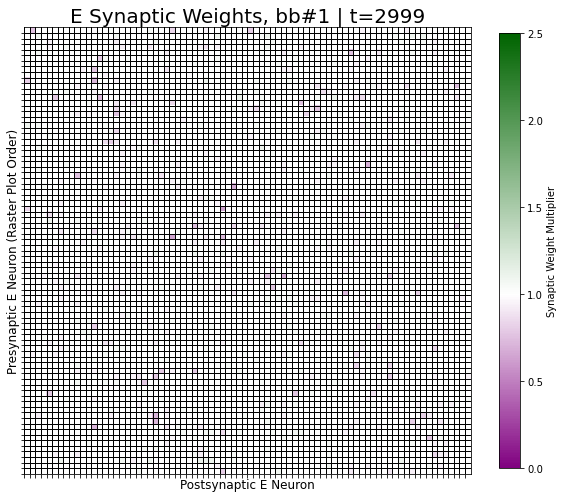

In [13]:
neurons,nc_Matrix = init_nrn(numnrn) #initializes neurons and creates universal list.
strengthen_backbone()
init_quad_colors() # Groups LE neurons based on intial connectivities to bbs.
strengthen_LE() #Must come after init_quad_colors().
change_Idrive()
def mainProgramLoop():
    
    for t_ind in range(Ntimes):
        
        #Records timing of spikes (in t/stepSize)
        updateSpikeTime(t_ind)
        #Updates the input synaptic current to be used in RK4
        updateSyn(t_ind)
        #A function to update the solutions for all neurons' D.E.s
        RK4(t_ind)

        vary_param(t_ind) #Checks t_ind to change network gks values. Also added backbone switching and plasticity.
        avg_conn_strength_bbs(t_ind) #Checks t_ind to see if quadrant conn multipliers should be recorded and matrix graphed.
        
        zeroTempVars() #Resets temporary variables like Isyn

    record_gaussian() #Records spike times as gussian curves.
    frequency_Theta()
    #plot_bb_mat(t_ind,bbs_toplot)
    plot_sorted_bb(0,nc_Matrix)
    #lower_count_array = count_recruited()
    plot_plasvstime_bb()
    beep(makeSound) #Plays beeps as last line of code.
    return 

mainProgramLoop()

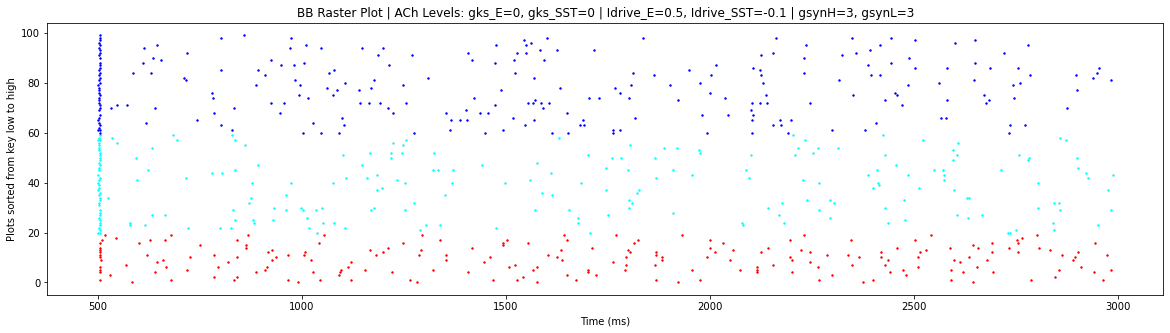

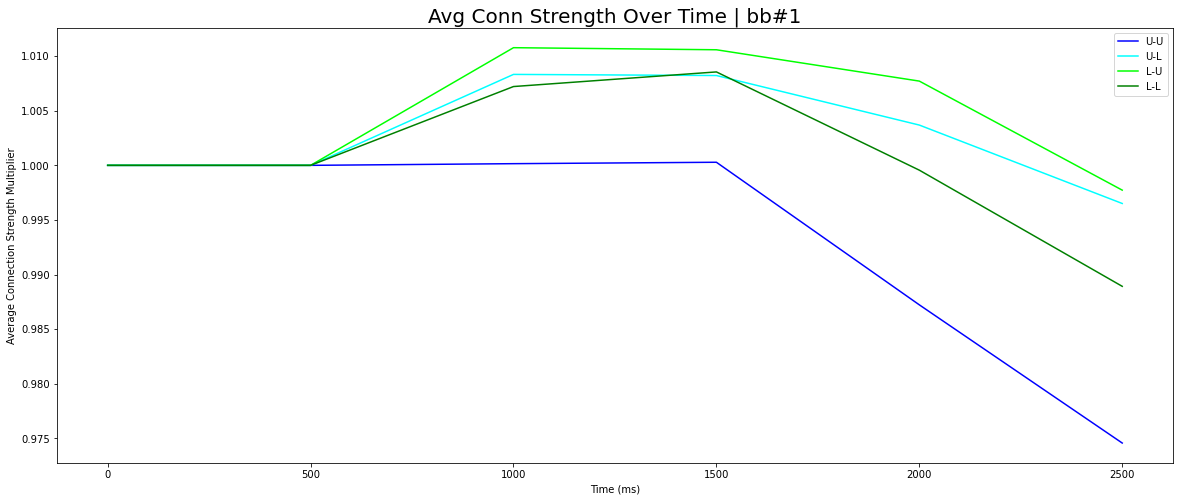

In [14]:
    plot_sorted_bb(0,nc_Matrix)

    plot_plasvstime_bb()

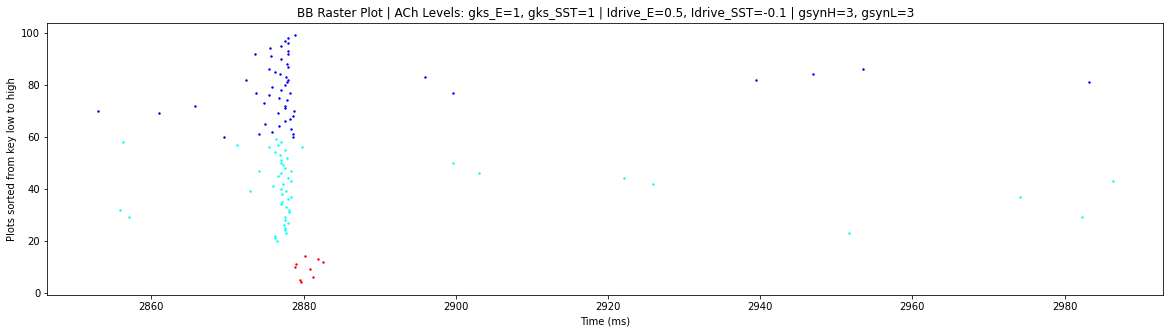

In [9]:
plot_sorted_bb(2850,nc_Matrix)